In [1]:
mkdir -p fin-distill-sentiment/{src,data,notebooks,scripts,configs,results,assets}

# Get pseudo-label

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    AlbertForSequenceClassification,
    get_linear_schedule_with_warmup
)

from sklearn.metrics import accuracy_score, f1_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---- Model names ----
TEACHER_MODEL_NAME = "ProsusAI/finbert"      # or "yiyanghkust/finbert-tone"
STUDENT_MODEL_NAME = "albert-base-v2"       # smallest ALBERT-v2 version

# ---- KD hyperparameters ----
NUM_LABELS   = 3     # FinBERT has 3 sentiment classes
MAX_LEN      = 128
BATCH_SIZE   = 32
LR           = 2e-5
NUM_EPOCHS   = 3

ALPHA        = 0.3   # weight on hard-label CE loss
TEMPERATURE  = 5.0   # soft-label softening factor

# Load tokenizers
teacher_tokenizer = AutoTokenizer.from_pretrained(TEACHER_MODEL_NAME)
student_tokenizer = AutoTokenizer.from_pretrained(STUDENT_MODEL_NAME)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


### Load FinBERT Teacher

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

TEACHER_MODEL_NAME = "ProsusAI/finbert"  # or your own FinBERT variant

teacher_tokenizer = AutoTokenizer.from_pretrained(TEACHER_MODEL_NAME)
teacher_model = AutoModelForSequenceClassification.from_pretrained(TEACHER_MODEL_NAME)
teacher_model.to(device)
teacher_model.eval()

print(teacher_model.config.id2label)  # e.g. {0: 'negative', 1: 'neutral', 2: 'positive'}

{0: 'positive', 1: 'negative', 2: 'neutral'}


### Load Scraped-data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import requests
import zipfile
import io
import pandas as pd

# 1) Load scraped CSV
csv_path = "/content/drive/MyDrive/MATH60629A_FinBERT-KD-Project/scraped_data.csv"  # set path
df_news = pd.read_csv(csv_path)

# Quick sanity check
print(df_news.head())
print(df_news.shape)

# 2) Build a text field for KD
def build_kd_text(row):
    # Can tune this; here we combine title + summary + text
    parts = []
    for col in ["title_clean", "summary_clean", "text_clean"]:
        if col in row and isinstance(row[col], str):
            parts.append(row[col])
    return " ".join(parts)

if "text_clean" in df_news.columns:
    df_news["kd_text"] = df_news.apply(build_kd_text, axis=1)
else:
    raise ValueError("Expected 'text_clean' (and/or title_clean/summary_clean) in scraped CSV.")

# Remove empty strings
df_news["kd_text"] = df_news["kd_text"].fillna("").str.strip()
df_news = df_news[df_news["kd_text"] != ""].reset_index(drop=True)

print("KD-pretraining samples:", len(df_news))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
                 datetime                                              title  \
0   11/15/2025 4:31:22 PM  NVDA vs. AMD vs AVGO: Which AI Chip Stock Is t...   
1   11/15/2025 4:30:00 PM  AMD vs. PLTR: Which Is the Better AI Stock ami...   
2   11/15/2025 3:15:00 PM  NVDA, MSFT, GOOGL: Ray Dalio’s Bridgewater Los...   
3   11/15/2025 1:58:04 PM  Should You Buy Nvidia Stock (NVDA) Ahead of Q3...   
4  11/14/2025 10:54:15 PM  NVDA, MSFT, GOOGL: Ray Dalio’s Bridgewater Los...   

     source                                               link  \
0  TipRanks  https://markets.businessinsider.com/news/stock...   
1  TipRanks  https://markets.businessinsider.com/news/stock...   
2  TipRanks  https://markets.businessinsider.com/news/stock...   
3  TipRanks  https://markets.businessinsider.com/news/stock...   
4  TipRanks  https://markets.businessinsider.com/news/stock.

### Run FinBERT over kd_text and create pseudo-labels

In [ ]:
import numpy as np
from torch.nn.functional import softmax

MAX_LEN = 128      # or same value used for student
BATCH_SIZE = 16    # tune based on GPU memory

texts = df_news["kd_text"].tolist()

all_hard_labels = []
all_logits      = []   # optional, for KD soft labels
all_probs       = []   # optional, for probabilities

for i in range(0, len(texts), BATCH_SIZE):
    batch_texts = texts[i : i + BATCH_SIZE]

    enc = teacher_tokenizer(
        batch_texts,
        truncation=True,
        padding=True,
        max_length=MAX_LEN,
        return_tensors="pt"
    ).to(device)

    with torch.no_grad():
        outputs = teacher_model(**enc)
        logits  = outputs.logits              # (batch_size, num_labels)
        probs   = softmax(logits, dim=-1)     # (batch_size, num_labels)
        preds   = torch.argmax(logits, dim=-1)

    all_hard_labels.extend(preds.cpu().tolist())
    all_logits.extend(logits.cpu().tolist())
    all_probs.extend(probs.cpu().tolist())

len(all_hard_labels), len(df_news)

(7982, 7982)

In [ ]:
df_news["teacher_label_id"] = all_hard_labels

# Optional: also store human-readable labels
id2label = teacher_model.config.id2label
df_news["teacher_label"] = df_news["teacher_label_id"].map(id2label)

print(df_news[["kd_text", "teacher_label_id", "teacher_label"]].head())

                                             kd_text  teacher_label_id  \
0  nvda vs. amd vs avgo: which ai chip stock is t...                 0   
1  amd vs. pltr: which is the better ai stock ami...                 2   
2  nvda, msft, googl: ray dalios bridgewater lose...                 1   
3  should you buy nvidia stock (nvda) ahead of q3...                 0   
4  nvda, msft, googl: ray dalios bridgewater lose...                 1   

  teacher_label  
0      positive  
1       neutral  
2      negative  
3      positive  
4      negative  


In [ ]:
# Save soft labels for KD
all_logits_arr = np.array(all_logits)   # shape: (N, num_labels)
all_probs_arr  = np.array(all_probs)    # shape: (N, num_labels)

np.save("/content/drive/MyDrive/MATH60629A_FinBERT-KD-Project/finbert_logits_scraped.npy",
        all_logits_arr)
np.save("/content/drive/MyDrive/MATH60629A_FinBERT-KD-Project/finbert_probs_scraped.npy",
        all_probs_arr)

# Train ALBERT CE-only on Scraped-data

In [ ]:
class ScrapedDataset(Dataset):
    def __init__(self, df):
        self.texts  = df["kd_text"].tolist()
        self.labels = df["teacher_label_id"].tolist()   # ints from FinBERT

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return {
            "text":  self.texts[idx],
            "label": self.labels[idx],
        }

In [ ]:
from sklearn.model_selection import train_test_split

df_train, df_temp = train_test_split(
    df_news,
    test_size=0.3,
    random_state=42,
    stratify=df_news["teacher_label_id"]
)

df_val, df_test = train_test_split(
    df_temp,
    test_size=0.5,
    random_state=42,
    stratify=df_temp["teacher_label_id"]
)

print(len(df_train), len(df_val), len(df_test))

5587 1197 1198


In [ ]:
train_dataset_scraped = ScrapedDataset(df_train)
val_dataset_scraped   = ScrapedDataset(df_val)
test_dataset_scraped  = ScrapedDataset(df_test)

In [ ]:
def collate_fn_student_only(batch):
    texts  = [item["text"]  for item in batch]
    labels = [item["label"] for item in batch]

    student_enc = student_tokenizer(
        texts,
        truncation=True,
        padding=True,
        max_length=MAX_LEN,
        return_tensors="pt"
    )

    labels = torch.tensor(labels, dtype=torch.long)

    return {
        "student_input_ids":      student_enc["input_ids"],
        "student_attention_mask": student_enc["attention_mask"],
        "labels":                 labels,
    }

In [ ]:
train_loader_ce_scraped = DataLoader(
    train_dataset_scraped,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=collate_fn_student_only
)

val_loader_ce_scraped = DataLoader(
    val_dataset_scraped,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_fn_student_only
)

test_loader_ce_scraped = DataLoader(
    test_dataset_scraped,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_fn_student_only
)

In [ ]:
ce_loss_fn = nn.CrossEntropyLoss()
NUM_LABELS = 3  # FinBERT: negative / neutral / positive

def train_one_epoch_ce(model, optimizer, scheduler, epoch, train_loader, tag="[CE-only]"):
    model.train()
    total_loss = 0.0

    for batch in train_loader:
        s_input_ids      = batch["student_input_ids"].to(device)
        s_attention_mask = batch["student_attention_mask"].to(device)
        labels           = batch["labels"].to(device)

        outputs = model(
            input_ids=s_input_ids,
            attention_mask=s_attention_mask
        )
        logits = outputs.logits

        loss = ce_loss_fn(logits, labels)

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"{tag} Epoch {epoch} | Train Loss: {avg_loss:.4f}")


def evaluate_on(model, loader, name="Eval"):
    model.eval()
    all_labels = []
    all_preds  = []

    with torch.no_grad():
        for batch in loader:
            s_input_ids      = batch["student_input_ids"].to(device)
            s_attention_mask = batch["student_attention_mask"].to(device)
            labels           = batch["labels"].to(device)

            outputs = model(
                input_ids=s_input_ids,
                attention_mask=s_attention_mask
            )
            logits = outputs.logits
            preds  = torch.argmax(logits, dim=-1)

            all_labels.extend(labels.cpu().tolist())
            all_preds.extend(preds.cpu().tolist())

    acc = accuracy_score(all_labels, all_preds)
    macro_f1 = f1_score(all_labels, all_preds, average="macro")
    print(f"{name} Accuracy: {acc:.4f} | {name} Macro-F1: {macro_f1:.4f}")
    return acc, macro_f1

In [ ]:
# Fresh student for scraped CE-only
student_model_scraped_ce = AlbertForSequenceClassification.from_pretrained(
    STUDENT_MODEL_NAME,
    num_labels=NUM_LABELS
).to(device)

optimizer_scraped_ce = torch.optim.AdamW(student_model_scraped_ce.parameters(), lr=LR)
total_steps_scraped_ce = len(train_loader_ce_scraped) * NUM_EPOCHS
scheduler_scraped_ce = get_linear_schedule_with_warmup(
    optimizer_scraped_ce,
    num_warmup_steps=int(0.1 * total_steps_scraped_ce),
    num_training_steps=total_steps_scraped_ce
)

best_macro_f1_scraped = 0.0
best_state_scraped    = None

for epoch in range(1, NUM_EPOCHS + 1):
    train_one_epoch_ce(
        student_model_scraped_ce,
        optimizer_scraped_ce,
        scheduler_scraped_ce,
        epoch,
        train_loader_ce_scraped,
        tag="[Scraped CE-only]"
    )
    acc, macro_f1 = evaluate_on(
        student_model_scraped_ce,
        val_loader_ce_scraped,
        name="[Scraped CE-only] Val"
    )

    if macro_f1 > best_macro_f1_scraped:
        best_macro_f1_scraped = macro_f1
        best_state_scraped    = student_model_scraped_ce.state_dict()

print(f"[Scraped CE-only] Best Val Macro-F1: {best_macro_f1_scraped:.4f}")

if best_state_scraped is not None:
    student_model_scraped_ce.load_state_dict(best_state_scraped)
    save_dir_scraped_ce = "albert_ce_only_scraped"
    student_model_scraped_ce.save_pretrained(save_dir_scraped_ce)
    student_tokenizer.save_pretrained(save_dir_scraped_ce)
    print(f"Saved Scraped CE-only student to {save_dir_scraped_ce}")

# Evaluate how well it imitates FinBERT on scraped test split
test_acc_scraped, test_macro_f1_scraped = evaluate_on(
    student_model_scraped_ce,
    test_loader_ce_scraped,
    name="Test (Scraped CE-only)"
)
print(
    f"Test (Scraped CE-only) Accuracy: {test_acc_scraped:.4f} | "
    f"Macro-F1: {test_macro_f1_scraped:.4f}"
)

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[Scraped CE-only] Epoch 1 | Train Loss: 0.5585
[Scraped CE-only] Val Accuracy: 0.8855 | [Scraped CE-only] Val Macro-F1: 0.8818
[Scraped CE-only] Epoch 2 | Train Loss: 0.2377
[Scraped CE-only] Val Accuracy: 0.9156 | [Scraped CE-only] Val Macro-F1: 0.9149
[Scraped CE-only] Epoch 3 | Train Loss: 0.1277
[Scraped CE-only] Val Accuracy: 0.9223 | [Scraped CE-only] Val Macro-F1: 0.9229
[Scraped CE-only] Best Val Macro-F1: 0.9229
Saved Scraped CE-only student to albert_ce_only_scraped
Test (Scraped CE-only) Accuracy: 0.9316 | Test (Scraped CE-only) Macro-F1: 0.9291
Test (Scraped CE-only) Accuracy: 0.9316 | Macro-F1: 0.9291


# Train ALBERT with Vanilla KD on Scraped-data

In [ ]:
class ScrapedKDDataset(Dataset):
    def __init__(self, df):
        self.texts  = df["kd_text"].tolist()
        self.labels = df["teacher_label_id"].tolist()   # FinBERT hard labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return {
            "text":  self.texts[idx],
            "label": self.labels[idx],
        }

print("KD scraped splits:", len(df_train), len(df_val), len(df_test))

train_dataset_kd_scraped = ScrapedKDDataset(df_train)
val_dataset_kd_scraped   = ScrapedKDDataset(df_val)
test_dataset_kd_scraped  = ScrapedKDDataset(df_test)

KD scraped splits: 5587 1197 1198


In [ ]:
def collate_fn_kd_scraped(batch):
    texts  = [item["text"]  for item in batch]
    labels = [item["label"] for item in batch]

    # Teacher encoding (FinBERT)
    teacher_enc = teacher_tokenizer(
        texts,
        truncation=True,
        padding=True,
        max_length=MAX_LEN,
        return_tensors="pt"
    )

    # Student encoding (ALBERT tokenizer – same as student_tokenizer)
    student_enc = student_tokenizer(
        texts,
        truncation=True,
        padding=True,
        max_length=MAX_LEN,
        return_tensors="pt"
    )

    labels = torch.tensor(labels, dtype=torch.long)

    return {
        "teacher_input_ids":      teacher_enc["input_ids"],
        "teacher_attention_mask": teacher_enc["attention_mask"],
        "student_input_ids":      student_enc["input_ids"],
        "student_attention_mask": student_enc["attention_mask"],
        "labels":                 labels,
    }

train_loader_kd_scraped = DataLoader(
    train_dataset_kd_scraped,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=collate_fn_kd_scraped
)

val_loader_kd_scraped = DataLoader(
    val_dataset_kd_scraped,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_fn_kd_scraped
)

test_loader_kd_scraped = DataLoader(
    test_dataset_kd_scraped,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_fn_kd_scraped
)

In [ ]:
import torch.nn as nn
from torch.nn.functional import softmax, log_softmax

ce_loss_fn  = nn.CrossEntropyLoss()
kl_loss_fn  = nn.KLDivLoss(reduction="batchmean")

def kd_loss_fn(student_logits, teacher_logits, labels,
               alpha=ALPHA, T=TEMPERATURE):
    # Hard-label CE loss
    ce_loss = ce_loss_fn(student_logits, labels)

    # Soft-label KD loss
    student_log_probs_T = log_softmax(student_logits / T, dim=-1)
    teacher_probs_T     = softmax(teacher_logits / T, dim=-1)

    kd_loss = kl_loss_fn(student_log_probs_T, teacher_probs_T) * (T ** 2)
    total_loss = alpha * ce_loss + (1 - alpha) * kd_loss

    # Detach individual components for logging
    return total_loss, ce_loss.detach(), kd_loss.detach()

In [ ]:
def train_one_epoch_kd_scraped(model, optimizer, scheduler, epoch, T, tag="[KD Scraped]"):
    model.train()
    teacher_model.eval()  # teacher is frozen

    total_loss = 0.0

    for batch in train_loader_kd_scraped:
        t_input_ids      = batch["teacher_input_ids"].to(device)
        t_attention_mask = batch["teacher_attention_mask"].to(device)
        s_input_ids      = batch["student_input_ids"].to(device)
        s_attention_mask = batch["student_attention_mask"].to(device)
        labels           = batch["labels"].to(device)

        # Teacher forward (FinBERT, no grad)
        with torch.no_grad():
            t_outputs = teacher_model(
                input_ids=t_input_ids,
                attention_mask=t_attention_mask
            )
            teacher_logits = t_outputs.logits

        # Student forward (ALBERT)
        s_outputs = model(
            input_ids=s_input_ids,
            attention_mask=s_attention_mask
        )
        student_logits = s_outputs.logits

        # KD loss with custom T
        loss, ce_part, kd_part = kd_loss_fn(
            student_logits,
            teacher_logits,
            labels,
            alpha=ALPHA,
            T=T
        )

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader_kd_scraped)
    print(f"{tag} (T={T}) Epoch {epoch} | Train Loss: {avg_loss:.4f}")

def evaluate_on_kd_scraped(model, loader, name="Eval (KD Scraped)"):
    model.eval()
    all_labels = []
    all_preds  = []

    with torch.no_grad():
        for batch in loader:
            s_input_ids      = batch["student_input_ids"].to(device)
            s_attention_mask = batch["student_attention_mask"].to(device)
            labels           = batch["labels"].to(device)

            outputs = model(
                input_ids=s_input_ids,
                attention_mask=s_attention_mask
            )
            logits = outputs.logits
            preds  = torch.argmax(logits, dim=-1)

            all_labels.extend(labels.cpu().tolist())
            all_preds.extend(preds.cpu().tolist())

    acc = accuracy_score(all_labels, all_preds)
    macro_f1 = f1_score(all_labels, all_preds, average="macro")
    print(f"{name} Accuracy: {acc:.4f} | {name} Macro-F1: {macro_f1:.4f}")
    return acc, macro_f1

In [ ]:
NUM_EPOCHS   = 3
temperatures_to_try = [2.0, 5.0, 9.0]

results_kd_scraped_T = []

for T in temperatures_to_try:
    print("\n" + "="*60)
    print(f"Training KD Scraped student with T = {T}")
    print("="*60)

    # Fresh ALBERT student for each T
    student_model = AlbertForSequenceClassification.from_pretrained(
        STUDENT_MODEL_NAME,
        num_labels=NUM_LABELS
    ).to(device)

    optimizer = torch.optim.AdamW(student_model.parameters(), lr=LR)
    total_steps = len(train_loader_kd_scraped) * NUM_EPOCHS

    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=int(0.1 * total_steps),
        num_training_steps=total_steps
    )

    best_macro_f1 = 0.0
    best_state    = None

    for epoch in range(1, NUM_EPOCHS + 1):
        train_one_epoch_kd_scraped(
            student_model,
            optimizer,
            scheduler,
            epoch,
            T=T,
            tag=f"[KD Scraped T={T}]"
        )

        val_acc, val_macro_f1 = evaluate_on_kd_scraped(
            student_model,
            val_loader_kd_scraped,
            name=f"[KD Scraped T={T}] Val"
        )

        if val_macro_f1 > best_macro_f1:
            best_macro_f1 = val_macro_f1
            best_state    = student_model.state_dict()

    print(f"[KD Scraped T={T}] Best Val Macro-F1: {best_macro_f1:.4f}")

    # Load best state and evaluate on scraped test split
    if best_state is not None:
        student_model.load_state_dict(best_state)

    test_acc, test_macro_f1 = evaluate_on_kd_scraped(
        student_model,
        test_loader_kd_scraped,
        name=f"Test (KD Scraped T={T})"
    )
    print(
        f"Test (KD Scraped T={T}) Accuracy: {test_acc:.4f} | "
        f"Macro-F1: {test_macro_f1:.4f}"
    )

    # Save model (for later PhraseBank fine-tuning)
    save_dir = f"albert_vanilla_kd_scraped_T{int(T)}"
    student_model.save_pretrained(save_dir)
    student_tokenizer.save_pretrained(save_dir)
    print(f"Saved KD Scraped student (T={T}) to {save_dir}")

    # Store results for later plotting / table
    results_kd_scraped_T.append({
        "T": T,
        "val_macro_f1": float(best_macro_f1),
        "test_acc": float(test_acc),
        "test_macro_f1": float(test_macro_f1),
        "save_dir": save_dir,
    })

print("\nKD Scraped Temperature Sweep Results:")
for r in results_kd_scraped_T:
    print(r)


Training KD Scraped student with T = 2.0


Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[KD Scraped T=2.0] (T=2.0) Epoch 1 | Train Loss: 0.4448
[KD Scraped T=2.0] Val Accuracy: 0.8997 | [KD Scraped T=2.0] Val Macro-F1: 0.8984
[KD Scraped T=2.0] (T=2.0) Epoch 2 | Train Loss: 0.1406
[KD Scraped T=2.0] Val Accuracy: 0.9298 | [KD Scraped T=2.0] Val Macro-F1: 0.9310
[KD Scraped T=2.0] (T=2.0) Epoch 3 | Train Loss: 0.0839
[KD Scraped T=2.0] Val Accuracy: 0.9357 | [KD Scraped T=2.0] Val Macro-F1: 0.9355
[KD Scraped T=2.0] Best Val Macro-F1: 0.9355
Test (KD Scraped T=2.0) Accuracy: 0.9341 | Test (KD Scraped T=2.0) Macro-F1: 0.9332
Test (KD Scraped T=2.0) Accuracy: 0.9341 | Macro-F1: 0.9332
Saved KD Scraped student (T=2.0) to albert_vanilla_kd_scraped_T2

Training KD Scraped student with T = 5.0


Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[KD Scraped T=5.0] (T=5.0) Epoch 1 | Train Loss: 0.5099
[KD Scraped T=5.0] Val Accuracy: 0.8839 | [KD Scraped T=5.0] Val Macro-F1: 0.8842
[KD Scraped T=5.0] (T=5.0) Epoch 2 | Train Loss: 0.1505
[KD Scraped T=5.0] Val Accuracy: 0.9223 | [KD Scraped T=5.0] Val Macro-F1: 0.9228
[KD Scraped T=5.0] (T=5.0) Epoch 3 | Train Loss: 0.0908
[KD Scraped T=5.0] Val Accuracy: 0.9332 | [KD Scraped T=5.0] Val Macro-F1: 0.9350
[KD Scraped T=5.0] Best Val Macro-F1: 0.9350
Test (KD Scraped T=5.0) Accuracy: 0.9382 | Test (KD Scraped T=5.0) Macro-F1: 0.9368
Test (KD Scraped T=5.0) Accuracy: 0.9382 | Macro-F1: 0.9368
Saved KD Scraped student (T=5.0) to albert_vanilla_kd_scraped_T5

Training KD Scraped student with T = 9.0


Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[KD Scraped T=9.0] (T=9.0) Epoch 1 | Train Loss: 0.4439
[KD Scraped T=9.0] Val Accuracy: 0.8739 | [KD Scraped T=9.0] Val Macro-F1: 0.8748
[KD Scraped T=9.0] (T=9.0) Epoch 2 | Train Loss: 0.1466
[KD Scraped T=9.0] Val Accuracy: 0.9198 | [KD Scraped T=9.0] Val Macro-F1: 0.9218
[KD Scraped T=9.0] (T=9.0) Epoch 3 | Train Loss: 0.0873
[KD Scraped T=9.0] Val Accuracy: 0.9398 | [KD Scraped T=9.0] Val Macro-F1: 0.9403
[KD Scraped T=9.0] Best Val Macro-F1: 0.9403
Test (KD Scraped T=9.0) Accuracy: 0.9366 | Test (KD Scraped T=9.0) Macro-F1: 0.9362
Test (KD Scraped T=9.0) Accuracy: 0.9366 | Macro-F1: 0.9362
Saved KD Scraped student (T=9.0) to albert_vanilla_kd_scraped_T9

KD Scraped Temperature Sweep Results:
{'T': 2.0, 'val_macro_f1': 0.9354992797988099, 'test_acc': 0.9340567612687813, 'test_macro_f1': 0.9332331994224082, 'save_dir': 'albert_vanilla_kd_scraped_T2'}
{'T': 5.0, 'val_macro_f1': 0.9349798610288268, 'test_acc': 0.9382303839732888, 'test_macro_f1': 0.9367569877725758, 'save_dir': 'albe

# Train ALBERT with Patient KD on Scraped-data

In [ ]:
# PKD hyperparameter
BETA_REP = 0.02  # strength of representation (hidden-state) distillation
NUM_EPOCHS   = 3

# Make sure teacher outputs hidden states
teacher_model.config.output_hidden_states = True

In [ ]:
# Fresh ALBERT student for PKD on scraped data
student_model_pkd_scraped = AlbertForSequenceClassification.from_pretrained(
    STUDENT_MODEL_NAME,
    num_labels=NUM_LABELS
).to(device)

# Enable hidden states for the student as well
student_model_pkd_scraped.config.output_hidden_states = True

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
student_layers = [2, 4, 8, 12]
layer_map = {j: j for j in student_layers}

print("PKD student_layers:", student_layers)
print("PKD layer_map:", layer_map)

PKD student_layers: [2, 4, 8, 12]
PKD layer_map: {2: 2, 4: 4, 8: 8, 12: 12}


In [ ]:
import torch.nn.functional as F

def l2_normalize(x, dim=-1, eps=1e-12):
    """L2-normalize over the last dimension."""
    return x / (x.norm(p=2, dim=dim, keepdim=True) + eps)

def pkd_rep_loss(student_hidden_states, teacher_hidden_states,
                 student_layers, layer_map, beta=BETA_REP):
    """
    student_hidden_states / teacher_hidden_states:
        list of tensors, length = num_layers+1 (includes embedding layer).
        Each element: (batch, seq_len, hidden_dim)
    student_layers:
        list of indices j in I_pt (indices into hidden_states list).
    layer_map:
        dict mapping student layer index -> teacher layer index g(j).
    """
    loss = 0.0
    for j in student_layers:
        # CLS token representations
        s_h = student_hidden_states[j][:, 0, :]            # (B, H)
        t_h = teacher_hidden_states[layer_map[j]][:, 0, :] # (B, H)

        s_h_norm = l2_normalize(s_h)
        t_h_norm = l2_normalize(t_h)

        # mean over batch
        loss += (s_h_norm - t_h_norm).pow(2).sum(dim=-1).mean()

    return beta * loss

In [ ]:
from transformers import get_linear_schedule_with_warmup

optimizer_pkd_scraped = torch.optim.AdamW(student_model_pkd_scraped.parameters(), lr=LR)
total_steps_pkd_scraped = len(train_loader_kd_scraped) * NUM_EPOCHS

scheduler_pkd_scraped = get_linear_schedule_with_warmup(
    optimizer_pkd_scraped,
    num_warmup_steps=int(0.1 * total_steps_pkd_scraped),
    num_training_steps=total_steps_pkd_scraped
)

In [ ]:
def train_one_epoch_pkd_scraped(
    model,
    optimizer,
    scheduler,
    epoch,
    student_layers,
    layer_map,
    tag="[PKD Scraped]",
    warmup_epochs=1,   # <-- number of epochs with KD only (no PKD)
):
    model.train()
    teacher_model.eval()  # teacher is frozen

    total_loss = 0.0

    for batch in train_loader_kd_scraped:
        t_input_ids      = batch["teacher_input_ids"].to(device)
        t_attention_mask = batch["teacher_attention_mask"].to(device)
        s_input_ids      = batch["student_input_ids"].to(device)
        s_attention_mask = batch["student_attention_mask"].to(device)
        labels           = batch["labels"].to(device)

        # ---- Teacher forward (FinBERT, with hidden states) ----
        with torch.no_grad():
            t_outputs = teacher_model(
                input_ids=t_input_ids,
                attention_mask=t_attention_mask
            )
            teacher_logits        = t_outputs.logits
            teacher_hidden_states = t_outputs.hidden_states  # list of (B, L, H)

        # ---- Student forward (ALBERT, with hidden states) ----
        s_outputs = model(
            input_ids=s_input_ids,
            attention_mask=s_attention_mask
        )
        student_logits        = s_outputs.logits
        student_hidden_states = s_outputs.hidden_states

        # ---- Vanilla KD loss on logits (CE + soft KL) ----
        kd_total, ce_part, kl_part = kd_loss_fn(
            student_logits,
            teacher_logits,
            labels,
            alpha=ALPHA,
            T=TEMPERATURE
        )

        # ---- PKD representation loss (CLS token alignment) ----
        if epoch > warmup_epochs:
            rep_loss = pkd_rep_loss(
                student_hidden_states,
                teacher_hidden_states,
                student_layers,
                layer_map,
                beta=BETA_REP
            )
        else:
            rep_loss = 0.0  # warm-up: no PKD in early epochs

        # ---- Total loss ----
        loss = kd_total + rep_loss

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader_kd_scraped)
    print(f"{tag} Epoch {epoch} | Train Loss: {avg_loss:.4f} "
          f"(warmup_epochs={warmup_epochs}, PKD_on={epoch > warmup_epochs})")

In [ ]:
def evaluate_on_kd_scraped(model, loader, name="Eval (KD Scraped)"):
    model.eval()
    all_labels = []
    all_preds  = []

    with torch.no_grad():
        for batch in loader:
            s_input_ids      = batch["student_input_ids"].to(device)
            s_attention_mask = batch["student_attention_mask"].to(device)
            labels           = batch["labels"].to(device)

            outputs = model(
                input_ids=s_input_ids,
                attention_mask=s_attention_mask
            )
            logits = outputs.logits
            preds  = torch.argmax(logits, dim=-1)

            all_labels.extend(labels.cpu().tolist())
            all_preds.extend(preds.cpu().tolist())

    acc = accuracy_score(all_labels, all_preds)
    macro_f1 = f1_score(all_labels, all_preds, average="macro")
    print(f"{name} Accuracy: {acc:.4f} | {name} Macro-F1: {macro_f1:.4f}")
    return acc, macro_f1

In [ ]:
best_macro_f1_pkd_scraped = 0.0
best_state_pkd_scraped    = None

WARMUP_EPOCHS = 1   # 1 epoch of pure KD, then KD+PKD

for epoch in range(1, NUM_EPOCHS + 1):
    train_one_epoch_pkd_scraped(
        student_model_pkd_scraped,
        optimizer_pkd_scraped,
        scheduler_pkd_scraped,
        epoch,
        student_layers,
        layer_map,
        tag="[PKD-scraped]",
        warmup_epochs=WARMUP_EPOCHS,
    )

    acc, macro_f1 = evaluate_on_kd_scraped(
        student_model_pkd_scraped,
        val_loader_kd_scraped,
        name="[PKD Scraped] Val"
    )

    if macro_f1 > best_macro_f1_pkd_scraped:
        best_macro_f1_pkd_scraped = macro_f1
        best_state_pkd_scraped    = student_model_pkd_scraped.state_dict()

print(f"[PKD Scraped] Best Val Macro-F1: {best_macro_f1_pkd_scraped:.4f}")

if best_state_pkd_scraped is not None:
    student_model_pkd_scraped.load_state_dict(best_state_pkd_scraped)
    save_dir_pkd_scraped = "albert_pkd_scraped"
    student_model_pkd_scraped.save_pretrained(save_dir_pkd_scraped)
    student_tokenizer.save_pretrained(save_dir_pkd_scraped)
    print(f"Saved PKD Scraped student to {save_dir_pkd_scraped}")

# Final test imitation performance
test_acc_pkd_scraped, test_macro_f1_pkd_scraped = evaluate_on_kd_scraped(
    student_model_pkd_scraped,
    test_loader_kd_scraped,
    name="Test (PKD Scraped)"
)
print(
    f"Test (PKD Scraped) Accuracy: {test_acc_pkd_scraped:.4f} | "
    f"Macro-F1: {test_macro_f1_pkd_scraped:.4f}"
)

[PKD-scraped] Epoch 1 | Train Loss: 0.4865 (warmup_epochs=1, PKD_on=False)
[PKD Scraped] Val Accuracy: 0.9073 | [PKD Scraped] Val Macro-F1: 0.9056
[PKD-scraped] Epoch 2 | Train Loss: 0.3506 (warmup_epochs=1, PKD_on=True)
[PKD Scraped] Val Accuracy: 0.9198 | [PKD Scraped] Val Macro-F1: 0.9191
[PKD-scraped] Epoch 3 | Train Loss: 0.2561 (warmup_epochs=1, PKD_on=True)
[PKD Scraped] Val Accuracy: 0.9348 | [PKD Scraped] Val Macro-F1: 0.9343
[PKD Scraped] Best Val Macro-F1: 0.9343
Saved PKD Scraped student to albert_pkd_scraped
Test (PKD Scraped) Accuracy: 0.9407 | Test (PKD Scraped) Macro-F1: 0.9394
Test (PKD Scraped) Accuracy: 0.9407 | Macro-F1: 0.9394


# Fine-tune on Financial Phrasebank 100% Agreements


In [ ]:
import requests
import zipfile
import io
import pandas as pd

# ------------------------------------------------------
# 1. Download the Financial PhraseBank ZIP
# ------------------------------------------------------
url = "https://huggingface.co/datasets/takala/financial_phrasebank/resolve/main/data/FinancialPhraseBank-v1.0.zip"

response = requests.get(url)
response.raise_for_status()

with zipfile.ZipFile(io.BytesIO(response.content)) as z:
    z.extractall("FinancialPhraseBank")

# ------------------------------------------------------
# 2. Load the FinancialPhraseBank file
# ------------------------------------------------------
filepath = "FinancialPhraseBank/FinancialPhraseBank-v1.0/Sentences_AllAgree.txt"
filepath_75 = "FinancialPhraseBank/FinancialPhraseBank-v1.0/Sentences_75Agree.txt"
filepath_50 = "FinancialPhraseBank/FinancialPhraseBank-v1.0/Sentences_50Agree.txt"

sentences = []
labels = []

with open(filepath, encoding="iso-8859-1") as f:
    for line in f:
        if "@" not in line:
            continue
        text, label = line.rsplit("@", 1)

        text = text.strip().replace("\xa0", " ")
        label = label.strip()

        sentences.append(text)
        labels.append(label)

# ------------------------------------------------------
# 3. Build DataFrame
# ------------------------------------------------------
label_to_id = {"positive": 0, "negative": 1, "neutral": 2}

fin_phrase_all_data = pd.DataFrame({
    "text": sentences,
    "label": labels
})

fin_phrase_all_data["label"] = fin_phrase_all_data["label"].map(label_to_id)

# fin_phrase_75_data = pd.DataFrame({
#     "text": sentences,
#     "label": labels
# })

# fin_phrase_75_data["label"] = fin_phrase_75_data["label"].map(label_to_id)

# fin_phrase_50_data = pd.DataFrame({
#     "text": sentences,
#     "label": labels
# })

# fin_phrase_50_data["label"] = fin_phrase_50_data["label"].map(label_to_id)

# # ------------------------------------------------------
# # 4. Shuffle the dataset
# # ------------------------------------------------------
fin_phrase_all_data = fin_phrase_all_data.sample(frac=1, random_state=42).reset_index(drop=True)
fin_phrase_all_data.head(), fin_phrase_all_data.shape

# fin_phrase_75_data = fin_phrase_75_data.sample(frac=1, random_state=42).reset_index(drop=True)
# fin_phrase_75_data.head(), fin_phrase_75_data.shape

# fin_phrase_50_data = fin_phrase_50_data.sample(frac=1, random_state=42).reset_index(drop=True)
# fin_phrase_50_data.head(), fin_phrase_50_data.shape

(                                                text  label
 0    The contract value amounts to EUR 2.4 million .      2
 1  Kemira shares closed at (  x20ac ) 16.66 ( $ 2...      2
 2  The company slipped to an operating loss of EU...      1
 3  According to Atria 's President and CEO Matti ...      0
 4  In 2009 , Fiskars ' cash flow from operating a...      0,
 (2264, 2))

In [ ]:
# ---- KD hyperparameters ----
NUM_LABELS   = 3     # FinBERT has 3 sentiment classes
MAX_LEN      = 128
BATCH_SIZE   = 32
LR           = 2e-5
NUM_EPOCHS   = 1

In [ ]:
class FinancialSentimentDataset(Dataset):
    def __init__(self, texts, labels):
        assert len(texts) == len(labels)
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return {
            "text":  self.texts[idx],
            "label": int(self.labels[idx])
        }

In [ ]:
from sklearn.model_selection import train_test_split

texts  = fin_phrase_all_data["text"].tolist()
labels = fin_phrase_all_data["label"].tolist()

# Train (70%) + temp (30%)
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    texts,
    labels,
    test_size=0.30,
    random_state=28,
    stratify=labels
)

# Validation (15%) + Test (15%)
val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts,
    temp_labels,
    test_size=0.50,
    random_state=28,
    stratify=temp_labels
)

print(
    len(train_texts),
    len(val_texts),
    len(test_texts)
)

train_dataset = FinancialSentimentDataset(train_texts, train_labels)
val_dataset   = FinancialSentimentDataset(val_texts,   val_labels)
test_dataset  = FinancialSentimentDataset(test_texts,  test_labels)

1584 340 340


In [ ]:
def collate_fn_student_only(batch):
    texts  = [item["text"]  for item in batch]
    labels = [item["label"] for item in batch]

    student_enc = student_tokenizer(
        texts,
        truncation=True,
        padding=True,
        max_length=MAX_LEN,
        return_tensors="pt"
    )

    labels = torch.tensor(labels, dtype=torch.long)

    return {
        "student_input_ids":      student_enc["input_ids"],
        "student_attention_mask": student_enc["attention_mask"],
        "labels":                 labels,
    }

train_loader_ce = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=collate_fn_student_only
)

val_loader_ce = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_fn_student_only
)

test_loader_ce = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_fn_student_only
)

In [ ]:
from transformers import AlbertForSequenceClassification, AutoTokenizer

NUM_LABELS = 3  # negative / neutral / positive

# Directories from your previous stage
ce_scraped_dir = "albert_ce_only_scraped"
kd_scraped_dir = "albert_vanilla_kd_scraped"
pkd_scraped_dir = "albert_pkd_scraped"

# 1) Fresh student: only pretrained as LM, no scraped pretraining
student_fresh_fp = AlbertForSequenceClassification.from_pretrained(
    STUDENT_MODEL_NAME,
    num_labels=NUM_LABELS
).to(device)

# 2) CE-only scraped student (from Stage 1)
ce_scraped_dir = "albert_ce_only_scraped"
student_ce_scraped = AlbertForSequenceClassification.from_pretrained(
    ce_scraped_dir,
    num_labels=NUM_LABELS
).to(device)

# 3) PKD scraped student (from Stage 1)
pkd_scraped_dir = "albert_pkd_scraped"
student_pkd_scraped = AlbertForSequenceClassification.from_pretrained(
    pkd_scraped_dir,
    num_labels=NUM_LABELS
).to(device)

# (Optional) reload tokenizer from one of them to rebuild loaders
student_tokenizer = AutoTokenizer.from_pretrained(ce_scraped_dir)

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
import torch
import torch.nn as nn
from transformers import get_linear_schedule_with_warmup
from sklearn.metrics import accuracy_score, f1_score

ce_loss_fn = nn.CrossEntropyLoss()

def train_one_epoch_fp(model, loader, optimizer, scheduler, epoch, tag="[FT FP]"):
    model.train()
    total_loss = 0.0

    for batch in loader:
        s_input_ids      = batch["student_input_ids"].to(device)
        s_attention_mask = batch["student_attention_mask"].to(device)
        labels           = batch["labels"].to(device)

        outputs = model(
            input_ids=s_input_ids,
            attention_mask=s_attention_mask
        )
        logits = outputs.logits
        loss   = ce_loss_fn(logits, labels)

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(loader)
    print(f"{tag} Epoch {epoch} | Train Loss: {avg_loss:.4f}")


def evaluate_on_fp(model, loader, name="[FT FP] Eval"):
    model.eval()
    all_labels = []
    all_preds  = []

    with torch.no_grad():
        for batch in loader:
            s_input_ids      = batch["student_input_ids"].to(device)
            s_attention_mask = batch["student_attention_mask"].to(device)
            labels           = batch["labels"].to(device)

            outputs = model(
                input_ids=s_input_ids,
                attention_mask=s_attention_mask
            )
            logits = outputs.logits
            preds  = torch.argmax(logits, dim=-1)

            all_labels.extend(labels.cpu().tolist())
            all_preds.extend(preds.cpu().tolist())

    acc = accuracy_score(all_labels, all_preds)
    macro_f1 = f1_score(all_labels, all_preds, average="macro")
    print(f"{name} Accuracy: {acc:.4f} | {name} Macro-F1: {macro_f1:.4f}")
    return acc, macro_f1

In [ ]:
def finetune_on_phrasebank(base_model,
                           train_loader,
                           val_loader,
                           test_loader,
                           tag_prefix="[Model → FP]",
                           save_dir=None,
                           num_epochs=NUM_EPOCHS,
                           lr=LR):
    """
    Fine-tunes a given model on Financial PhraseBank using CE-only,
    tracks best val Macro-F1, saves best checkpoint, and evaluates on test.
    """
    model = base_model  # already on device
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

    total_steps = len(train_loader) * num_epochs
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=int(0.1 * total_steps),
        num_training_steps=total_steps
    )

    best_macro_f1 = 0.0
    best_state    = None

    for epoch in range(1, num_epochs + 1):
        train_one_epoch_fp(
            model,
            train_loader,
            optimizer,
            scheduler,
            epoch,
            tag=f"{tag_prefix} CE"
        )

        acc, macro_f1 = evaluate_on_fp(
            model,
            val_loader,
            name=f"{tag_prefix} Val"
        )

        if macro_f1 > best_macro_f1:
            best_macro_f1 = macro_f1
            best_state    = model.state_dict()

    print(f"{tag_prefix} Best Val Macro-F1: {best_macro_f1:.4f}")

    if best_state is not None:
        model.load_state_dict(best_state)

        if save_dir is not None:
            model.save_pretrained(save_dir)
            student_tokenizer.save_pretrained(save_dir)
            print(f"Saved best {tag_prefix} model to {save_dir}")

    # Final test performance
    test_acc, test_macro_f1 = evaluate_on_fp(
        model,
        test_loader,
        name=f"{tag_prefix} Test"
    )
    print(
        f"{tag_prefix} Test Accuracy: {test_acc:.4f} | "
        f"Macro-F1: {test_macro_f1:.4f}"
    )

    return {
        "best_val_macro_f1": best_macro_f1,
        "test_acc": test_acc,
        "test_macro_f1": test_macro_f1,
        "model": model,
    }

In [ ]:
# 1) Fresh ALBERT → FP (no scraped pretraining)
results_fresh_fp = finetune_on_phrasebank(
    base_model=student_fresh_fp,
    train_loader=train_loader_ce,
    val_loader=val_loader_ce,
    test_loader=test_loader_ce,
    tag_prefix="[100% Agree - Fresh → FP]",
    save_dir="albert_fresh_finetuned_100phrasebank",
    num_epochs=NUM_EPOCHS,
    lr=LR
)

# 2) CE-only scraped → FP
results_ce_scraped_fp = finetune_on_phrasebank(
    base_model=student_ce_scraped,
    train_loader=train_loader_ce,
    val_loader=val_loader_ce,
    test_loader=test_loader_ce,
    tag_prefix="[100% Agree - CE-scraped → FP]",
    save_dir="albert_ce_scraped_finetuned_100phrasebank",
    num_epochs=NUM_EPOCHS,
    lr=LR
)

# 3) PKD-scraped → FP
results_pkd_scraped_fp = finetune_on_phrasebank(
    base_model=student_pkd_scraped,
    train_loader=train_loader_ce,
    val_loader=val_loader_ce,
    test_loader=test_loader_ce,
    tag_prefix="[100% Agree - PKD-scraped → FP]",
    save_dir="albert_pkd_scraped_finetuned_100phrasebank",
    num_epochs=NUM_EPOCHS,
    lr=LR
)

[100% Agree - Fresh → FP] CE Epoch 1 | Train Loss: 0.6202
[100% Agree - Fresh → FP] Val Accuracy: 0.7912 | [100% Agree - Fresh → FP] Val Macro-F1: 0.5311
[100% Agree - Fresh → FP] Best Val Macro-F1: 0.5311
Saved best [100% Agree - Fresh → FP] model to albert_fresh_finetuned_100phrasebank
[100% Agree - Fresh → FP] Test Accuracy: 0.8029 | [100% Agree - Fresh → FP] Test Macro-F1: 0.5544
[100% Agree - Fresh → FP] Test Accuracy: 0.8029 | Macro-F1: 0.5544
[100% Agree - CE-scraped → FP] CE Epoch 1 | Train Loss: 0.2228
[100% Agree - CE-scraped → FP] Val Accuracy: 0.9706 | [100% Agree - CE-scraped → FP] Val Macro-F1: 0.9631
[100% Agree - CE-scraped → FP] Best Val Macro-F1: 0.9631
Saved best [100% Agree - CE-scraped → FP] model to albert_ce_scraped_finetuned_100phrasebank
[100% Agree - CE-scraped → FP] Test Accuracy: 0.9529 | [100% Agree - CE-scraped → FP] Test Macro-F1: 0.9313
[100% Agree - CE-scraped → FP] Test Accuracy: 0.9529 | Macro-F1: 0.9313
[100% Agree - PKD-scraped → FP] CE Epoch 1 | Tr

In [ ]:
temps_and_dirs = [
    (2,  "albert_vanilla_kd_scraped_T2"),
    (5,  "albert_vanilla_kd_scraped_T5"),
    (9, "albert_vanilla_kd_scraped_T9"),
]

results_kd_T_fp = {}

for T, model_dir in temps_and_dirs:
    print(f"\n=== Fine-tuning KD-scraped model with T={T} on PhraseBank ===")

    student_kd_T = AlbertForSequenceClassification.from_pretrained(
        model_dir,
        num_labels=NUM_LABELS
    ).to(device)

    res = finetune_on_phrasebank(
        base_model=student_kd_T,
        train_loader=train_loader_ce,
        val_loader=val_loader_ce,
        test_loader=test_loader_ce,
        tag_prefix=f"[100% Agree - KD-scraped T={T} → FP]",
        save_dir=f"albert_kd_scraped_T{int(T)}_finetuned_100phrasebank",
        num_epochs=NUM_EPOCHS,
        lr=LR,
    )

    results_kd_T_fp[T] = res


=== Fine-tuning KD-scraped model with T=2 on PhraseBank ===
[100% Agree - KD-scraped T=2 → FP] CE Epoch 1 | Train Loss: 0.1626
[100% Agree - KD-scraped T=2 → FP] Val Accuracy: 0.9794 | [100% Agree - KD-scraped T=2 → FP] Val Macro-F1: 0.9712
[100% Agree - KD-scraped T=2 → FP] Best Val Macro-F1: 0.9712
Saved best [100% Agree - KD-scraped T=2 → FP] model to albert_kd_scraped_T2_finetuned_100phrasebank
[100% Agree - KD-scraped T=2 → FP] Test Accuracy: 0.9588 | [100% Agree - KD-scraped T=2 → FP] Test Macro-F1: 0.9460
[100% Agree - KD-scraped T=2 → FP] Test Accuracy: 0.9588 | Macro-F1: 0.9460

=== Fine-tuning KD-scraped model with T=5 on PhraseBank ===
[100% Agree - KD-scraped T=5 → FP] CE Epoch 1 | Train Loss: 0.1365
[100% Agree - KD-scraped T=5 → FP] Val Accuracy: 0.9735 | [100% Agree - KD-scraped T=5 → FP] Val Macro-F1: 0.9630
[100% Agree - KD-scraped T=5 → FP] Best Val Macro-F1: 0.9630
Saved best [100% Agree - KD-scraped T=5 → FP] model to albert_kd_scraped_T5_finetuned_100phrasebank
[1

# Confusion Matrix

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

label_id2name = {0: "negative", 1: "neutral", 2: "positive"}
label_order = [0, 1, 2]
label_names = ["negative", "neutral", "positive"]

In [ ]:
def get_phrasebank_preds(model, loader):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for batch in loader:
            input_ids = batch["student_input_ids"].to(device)
            attention_mask = batch["student_attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            preds = torch.argmax(outputs.logits, dim=-1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    return np.array(y_true), np.array(y_pred)

In [ ]:
def print_confusion_analysis(model, loader, model_name):
    y_true, y_pred = get_phrasebank_preds(model, loader)

    # Raw confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=label_order)

    # Normalized confusion matrix (row-wise)
    cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)

    print("\n" + "=" * 60)
    print(f"{model_name} — Confusion Matrix (rows=true, cols=pred)")
    print("Labels:", label_names)
    print(cm)

    print("\nNormalized Confusion Matrix (row-wise):")
    for i, row in enumerate(cm_norm):
        print(f"{label_names[i]:>9}: {row}")

    print("\nClassification Report:")
    print(classification_report(
        y_true, y_pred,
        target_names=label_names,
        digits=4
    ))

    return cm, cm_norm

In [ ]:
cm_fresh, cm_fresh_norm = print_confusion_analysis(
    results_fresh_fp["model"],
    test_loader_ce,
    model_name="Fresh → PhraseBank"
)

cm_ce, cm_ce_norm = print_confusion_analysis(
    results_ce_scraped_fp["model"],
    test_loader_ce,
    model_name="CE-scraped → PhraseBank"
)

model_dir_T5 = "albert_kd_scraped_T5_finetuned_100phrasebank"

results_kd_scraped_fp = AlbertForSequenceClassification.from_pretrained(
    model_dir_T5,
    num_labels=NUM_LABELS
).to(device)

cm_kd_T5, cm_kd_T5_norm = print_confusion_analysis(
    results_kd_scraped_fp,
    test_loader_ce,
    model_name="KD-scraped T=5 → PhraseBank"
)


cm_pkd, cm_pkd_norm = print_confusion_analysis(
    results_pkd_scraped_fp["model"],
    test_loader_ce,
    model_name="PKD-scraped → PhraseBank"
)


Fresh → PhraseBank — Confusion Matrix (rows=true, cols=pred)
Labels: ['negative', 'neutral', 'positive']
[[ 67   0  18]
 [ 41   1   4]
 [  4   0 205]]

Normalized Confusion Matrix (row-wise):
 negative: [0.78823529 0.         0.21176471]
  neutral: [0.89130435 0.02173913 0.08695652]
 positive: [0.01913876 0.         0.98086124]

Classification Report:
              precision    recall  f1-score   support

    negative     0.5982    0.7882    0.6802        85
     neutral     1.0000    0.0217    0.0426        46
    positive     0.9031    0.9809    0.9404       209

    accuracy                         0.8029       340
   macro avg     0.8338    0.5969    0.5544       340
weighted avg     0.8400    0.8029    0.7539       340


CE-scraped → PhraseBank — Confusion Matrix (rows=true, cols=pred)
Labels: ['negative', 'neutral', 'positive']
[[ 81   2   2]
 [  3  38   5]
 [  4   0 205]]

Normalized Confusion Matrix (row-wise):
 negative: [0.95294118 0.02352941 0.02352941]
  neutral: [0.065217

# Temperature Sweep with Vanilla KD on Phrasebank

In [ ]:
for T in sorted(results_kd_T_fp.keys()):
    res = results_kd_T_fp[T]
    print(
        f"T = {T} | "
        f"Val Macro-F1 = {res['best_val_macro_f1']:.4f} | "
        f"Test Acc = {res['test_acc']:.4f} | "
        f"Test Macro-F1 = {res['test_macro_f1']:.4f}"
    )

T = 2 | Val Macro-F1 = 0.9712 | Test Acc = 0.9588 | Test Macro-F1 = 0.9460
T = 5 | Val Macro-F1 = 0.9630 | Test Acc = 0.9647 | Test Macro-F1 = 0.9525
T = 9 | Val Macro-F1 = 0.9719 | Test Acc = 0.9588 | Test Macro-F1 = 0.9434


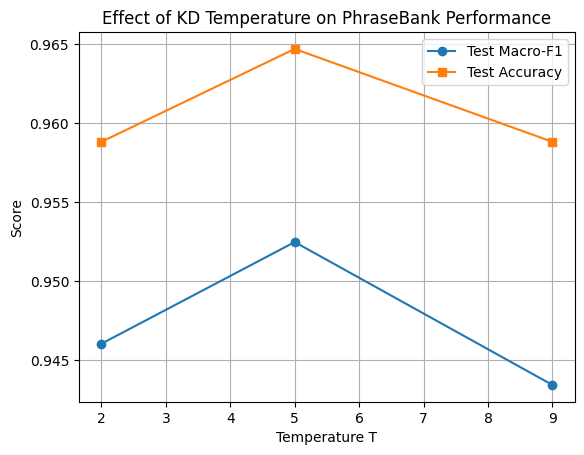

In [ ]:
import matplotlib.pyplot as plt

Ts = sorted(results_kd_T_fp.keys())
test_macro_f1s = [results_kd_T_fp[T]["test_macro_f1"] for T in Ts]
test_accs      = [results_kd_T_fp[T]["test_acc"] for T in Ts]

plt.plot(Ts, test_macro_f1s, marker="o", label="Test Macro-F1")
plt.plot(Ts, test_accs,      marker="s", label="Test Accuracy")

plt.xlabel("Temperature T")
plt.ylabel("Score")
plt.title("Effect of KD Temperature on PhraseBank Performance")
plt.legend()
plt.grid(True)
plt.show()

# Efficiency + Transfer diagnostics

In [ ]:
# Students (fine-tuned on FP)
fresh_dir = "albert_fresh_finetuned_100phrasebank"
ce_fp_dir = "albert_ce_scraped_finetuned_100phrasebank"
kd_fp_dir = "albert_kd_scraped_T5_finetuned_100phrasebank"
pkd_fp_dir = "albert_pkd_scraped_finetuned_100phrasebank"

from transformers import AlbertForSequenceClassification, AutoTokenizer

student_fresh_fp = AlbertForSequenceClassification.from_pretrained(fresh_dir).to(device)
student_ce_fp    = AlbertForSequenceClassification.from_pretrained(ce_fp_dir).to(device)
student_kd_fp    = AlbertForSequenceClassification.from_pretrained(kd_fp_dir).to(device)
student_pkd_fp   = AlbertForSequenceClassification.from_pretrained(pkd_fp_dir).to(device)


# Teacher (FinBERT)
from transformers import AutoModelForSequenceClassification
teacher_model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
texts_fp  = [item["text"]  for item in test_dataset]
labels_fp = [item["label"] for item in test_dataset]
len(texts_fp), len(labels_fp)

(340, 340)

# Helper: parameter count & approximate size

In [ ]:
def get_model_stats(model):
    n_params = sum(p.numel() for p in model.parameters())
    size_mb  = n_params * 4 / (1024**2)  # float32 ~ 4 bytes
    return n_params, size_mb

In [ ]:
for name, model in [
    ("Teacher FinBERT", teacher_model),
    ("Fresh → FP",      student_fresh_fp),
    ("CE-scraped → FP", student_ce_fp),
    ("KD-scraped → FP", student_kd_fp),
    ("PKD-scraped → FP", student_pkd_fp),
]:
    n, mb = get_model_stats(model)
    print(f"{name}: {n/1e6:.2f}M params, ~{mb:.1f} MB")

Teacher FinBERT: 109.48M params, ~417.7 MB
Fresh → FP: 11.69M params, ~44.6 MB
CE-scraped → FP: 11.69M params, ~44.6 MB
KD-scraped → FP: 11.69M params, ~44.6 MB
PKD-scraped → FP: 11.69M params, ~44.6 MB


# Helper: inference latency & throughput on FP test

This measures tokenization + model forward (realistic end-to-end inference)

In [ ]:
import time
import torch
from torch.nn.functional import softmax
from sklearn.metrics import accuracy_score, f1_score

teacher_model.to(device)
student_fresh_fp.to(device)
student_ce_fp.to(device)
student_kd_fp.to(device)
student_pkd_fp.to(device)


def benchmark_model_on_texts(
    model,
    tokenizer,
    texts,
    labels,
    batch_size=32,
    max_len=128,
    device=device,
    name="Model"
):
    model.eval()
    all_preds = []
    all_labels = labels

    start = time.time()

    with torch.no_grad():
        for i in range(0, len(texts), batch_size):
            batch_texts = texts[i: i + batch_size]
            enc = tokenizer(
                batch_texts,
                truncation=True,
                padding=True,
                max_length=max_len,
                return_tensors="pt"
            ).to(device)

            outputs = model(**enc)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=-1)
            all_preds.extend(preds.cpu().tolist())

    end = time.time()
    elapsed = end - start

    n_docs = len(texts)
    ms_per_doc = (elapsed / n_docs) * 1000.0
    docs_per_sec = n_docs / elapsed

    acc = accuracy_score(all_labels, all_preds)
    macro_f1 = f1_score(all_labels, all_preds, average="macro")

    print(
        f"{name}: Acc={acc:.4f}, Macro-F1={macro_f1:.4f}, "
        f"{ms_per_doc:.2f} ms/doc, {docs_per_sec:.1f} docs/s"
    )

    return {
        "acc": acc,
        "macro_f1": macro_f1,
        "ms_per_doc": ms_per_doc,
        "docs_per_sec": docs_per_sec,
    }

In [ ]:
results_eff = {}

results_eff["Fresh → FP"] = benchmark_model_on_texts(
    student_fresh_fp, student_tokenizer, texts_fp, labels_fp,
    batch_size=32, max_len=128, name="Fresh → FP"
)

results_eff["CE-scraped → FP"] = benchmark_model_on_texts(
    student_ce_fp, student_tokenizer, texts_fp, labels_fp,
    batch_size=32, max_len=128, name="CE-scraped → FP"
)

results_eff["KD-scraped → FP"] = benchmark_model_on_texts(
    student_kd_fp, student_tokenizer, texts_fp, labels_fp,
    batch_size=32, max_len=128, name="KD-scraped → FP"
)

results_eff["PKD-scraped → FP"] = benchmark_model_on_texts(
    student_pkd_fp, student_tokenizer, texts_fp, labels_fp,
    batch_size=32, max_len=128, name="PKD-scraped → FP"
)

results_eff["Teacher FinBERT"] = benchmark_model_on_texts(
    teacher_model, teacher_tokenizer, texts_fp, labels_fp,
    batch_size=32, max_len=128, name="Teacher FinBERT"
)

Fresh → FP: Acc=0.8029, Macro-F1=0.5544, 2.02 ms/doc, 495.2 docs/s
CE-scraped → FP: Acc=0.9529, Macro-F1=0.9313, 2.06 ms/doc, 485.5 docs/s
KD-scraped → FP: Acc=0.9647, Macro-F1=0.9525, 2.04 ms/doc, 490.8 docs/s
PKD-scraped → FP: Acc=0.9735, Macro-F1=0.9626, 2.03 ms/doc, 491.9 docs/s
Teacher FinBERT: Acc=0.9765, Macro-F1=0.9696, 1.49 ms/doc, 671.8 docs/s


In [ ]:
import time
student_model = AlbertForSequenceClassification.from_pretrained(
    STUDENT_MODEL_NAME,
    num_labels=NUM_LABELS
).to(device)

batch_texts = texts_fp[:64]

# 1) Tokenization only
t0 = time.time()
enc = student_tokenizer(
    batch_texts,
    truncation=True,
    padding=True,
    max_length=128,
    return_tensors="pt"
)
t1 = time.time()
print("Student tokenization:", (t1 - t0) * 1000, "ms")

# 2) Model forward only
enc = enc.to(device)
with torch.no_grad():
    if device.type == "cuda":
        torch.cuda.synchronize()
    t2 = time.time()
    outputs = student_pkd_fp(**enc)
    if device.type == "cuda":
        torch.cuda.synchronize()
    t3 = time.time()
print("Student forward:", (t3 - t2) * 1000, "ms")

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Student tokenization: 8.34202766418457 ms
Student forward: 149.45626258850098 ms


In [ ]:
import time

batch_texts = texts_fp[:64]

# 1) Tokenization only
t0 = time.time()
enc = teacher_tokenizer(
    batch_texts,
    truncation=True,
    padding=True,
    max_length=128,
    return_tensors="pt"
)
t1 = time.time()
print("Teacher tokenization:", (t1 - t0) * 1000, "ms")

# 2) Model forward only
enc = enc.to(device)
with torch.no_grad():
    if device.type == "cuda":
        torch.cuda.synchronize()
    t2 = time.time()
    outputs = teacher_model(**enc)
    if device.type == "cuda":
        torch.cuda.synchronize()
    t3 = time.time()
print("Teacher forward:", (t3 - t2) * 1000, "ms")


Teacher tokenization: 9.051084518432617 ms
Teacher forward: 91.4609432220459 ms


# Helper: KL divergence teacher → student on FP test

This is a transfer diagnostic: how close are the student predictions to the teacher’s distribution on the same FP texts

Expect:

- KD-scraped → FP to have the lowest KL (closest to teacher).

- Fresh → FP likely has the highest KL (most different behaviour).

In [ ]:
import torch.nn.functional as F

def avg_kl_teacher_student(
    teacher_model,
    teacher_tokenizer,
    student_model,
    student_tokenizer,
    texts,
    batch_size=32,
    max_len=128,
    device=device,
    name="Student"
):
    teacher_model.eval()
    student_model.eval()

    total_kl = 0.0
    n_batches = 0

    with torch.no_grad():
        for i in range(0, len(texts), batch_size):
            batch_texts = texts[i: i + batch_size]

            # Teacher
            t_enc = teacher_tokenizer(
                batch_texts,
                truncation=True,
                padding=True,
                max_length=max_len,
                return_tensors="pt"
            ).to(device)
            t_logits = teacher_model(**t_enc).logits
            t_probs  = F.softmax(t_logits, dim=-1)

            # Student
            s_enc = student_tokenizer(
                batch_texts,
                truncation=True,
                padding=True,
                max_length=max_len,
                return_tensors="pt"
            ).to(device)
            s_logits = student_model(**s_enc).logits
            s_log_probs = F.log_softmax(s_logits, dim=-1)

            # KL(teacher || student)
            kl = F.kl_div(s_log_probs, t_probs, reduction="batchmean")
            total_kl += kl.item()
            n_batches += 1

    avg_kl = total_kl / n_batches
    print(f"{name}: avg KL(teacher || student) = {avg_kl:.4f}")
    return avg_kl

In [ ]:
kl_results = {}

kl_results["Fresh → FP"] = avg_kl_teacher_student(
    teacher_model, teacher_tokenizer,
    student_fresh_fp, student_tokenizer,
    texts_fp,
    batch_size=32, max_len=128,
    name="Fresh → FP"
)

kl_results["CE-scraped → FP"] = avg_kl_teacher_student(
    teacher_model, teacher_tokenizer,
    student_ce_fp, student_tokenizer,
    texts_fp,
    batch_size=32, max_len=128,
    name="CE-scraped → FP"
)

kl_results["KD-scraped → FP"] = avg_kl_teacher_student(
    teacher_model, teacher_tokenizer,
    student_kd_fp, student_tokenizer,
    texts_fp,
    batch_size=32, max_len=128,
    name="KD-scraped → FP"
)

kl_results["PKD-scraped → FP"] = avg_kl_teacher_student(
    teacher_model, teacher_tokenizer,
    student_pkd_fp, student_tokenizer,
    texts_fp,
    batch_size=32, max_len=128,
    name="PKD-scraped → FP"
)

Fresh → FP: avg KL(teacher || student) = 0.3418
CE-scraped → FP: avg KL(teacher || student) = 0.2334
KD-scraped → FP: avg KL(teacher || student) = 0.1427
PKD-scraped → FP: avg KL(teacher || student) = 0.1339


# Build a summary DataFrame (for plots & tables)

Create:

- Accuracy vs Parameters plot

- Accuracy vs Latency (ms/doc) plot

- Speedup vs teacher: teacher_ms / student_ms

In [ ]:
import pandas as pd

rows = []
for name, model in [
    ("Teacher FinBERT", teacher_model),
    ("Fresh → FP",      student_fresh_fp),
    ("CE-scraped → FP", student_ce_fp),
    ("KD-scraped → FP", student_kd_fp),
    ("PKD-scraped → FP", student_pkd_fp),
]:
    n_params, size_mb = get_model_stats(model)
    eff = results_eff[name] if name in results_eff else {"acc": None, "macro_f1": None, "ms_per_doc": None, "docs_per_sec": None}
    kl  = None if name == "Teacher FinBERT" else kl_results.get(name, None)

    rows.append({
        "Model": name,
        "Params_M": n_params / 1e6,
        "Size_MB": size_mb,
        "Test_Acc": eff["acc"],
        "Test_MacroF1": eff["macro_f1"],
        "ms_per_doc": eff["ms_per_doc"],
        "docs_per_sec": eff["docs_per_sec"],
        "KL_teacher_to_student": kl,
    })

df_summary = pd.DataFrame(rows)
print(df_summary)
print(df_summary.to_latex(index=False, float_format="%.4f"))

              Model    Params_M     Size_MB  Test_Acc  Test_MacroF1  \
0   Teacher FinBERT  109.484547  417.650402  0.976471      0.969629   
1        Fresh → FP   11.685891   44.578136  0.802941      0.554374   
2   CE-scraped → FP   11.685891   44.578136  0.952941      0.931336   
3   KD-scraped → FP   11.685891   44.578136  0.964706      0.952471   
4  PKD-scraped → FP   11.685891   44.578136  0.973529      0.962559   

   ms_per_doc  docs_per_sec  KL_teacher_to_student  
0    1.488630    671.758818                    NaN  
1    2.019252    495.232766               0.341806  
2    2.059827    485.477633               0.233387  
3    2.037424    490.815806               0.142689  
4    2.032746    491.945479               0.133859  
\begin{tabular}{lrrrrrrr}
\toprule
Model & Params_M & Size_MB & Test_Acc & Test_MacroF1 & ms_per_doc & docs_per_sec & KL_teacher_to_student \\
\midrule
Teacher FinBERT & 109.4845 & 417.6504 & 0.9765 & 0.9696 & 1.4886 & 671.7588 & NaN \\
Fresh → FP & 11.68

In [ ]:
teacher_ms = df_summary.loc[df_summary["Model"]=="Teacher FinBERT", "ms_per_doc"].values[0]
df_summary["speedup_vs_teacher"] = teacher_ms / df_summary["ms_per_doc"]
print(df_summary[["Model", "Test_MacroF1", "ms_per_doc", "speedup_vs_teacher"]])

              Model  Test_MacroF1  ms_per_doc  speedup_vs_teacher
0   Teacher FinBERT      0.969629    1.488630            1.000000
1        Fresh → FP      0.554374    2.019252            0.737218
2   CE-scraped → FP      0.931336    2.059827            0.722696
3   KD-scraped → FP      0.952471    2.037424            0.730643
4  PKD-scraped → FP      0.962559    2.032746            0.732325


# Statistics on Scraped Data


## Helper Functions

### Model Summary

In [ ]:
import time
import torch
import os
import numpy as np
from sklearn.metrics import accuracy_score, f1_score
from tabulate import tabulate
import matplotlib.pyplot as plt

def model_summary_table(model, loader, model_name="Model", return_values=False):
    model.eval()
    all_labels = []
    all_preds  = []

    # Accuracy + Micro F1
    with torch.no_grad():
        for batch in loader:
            ids  = batch["student_input_ids"].to(device)
            mask = batch["student_attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids=ids, attention_mask=mask)
            logits  = outputs.logits
            preds   = torch.argmax(logits, dim=-1)

            all_labels.extend(labels.cpu().tolist())
            all_preds.extend(preds.cpu().tolist())

    accuracy = accuracy_score(all_labels, all_preds)
    macro_f1 = f1_score(all_labels, all_preds, average="macro")

    # Inference time on 1 sample
    sample_ids  = ids[:1]
    sample_mask = mask[:1]

    if torch.cuda.is_available():
        torch.cuda.synchronize()
    start = time.time()
    with torch.no_grad():
        for _ in range(50):
            _ = model(input_ids=sample_ids, attention_mask=sample_mask)
    if torch.cuda.is_available():
        torch.cuda.synchronize()
    infer_ms = (time.time() - start) / 50 * 1000

    # Model size
    tmp_dir = "tmp_model_size"
    os.makedirs(tmp_dir, exist_ok=True)
    model.save_pretrained(tmp_dir)
    size_mb = sum(
        os.path.getsize(os.path.join(tmp_dir, f)) for f in os.listdir(tmp_dir)
    ) / (1024 * 1024)
    for f in os.listdir(tmp_dir):
        os.remove(os.path.join(tmp_dir, f))
    os.rmdir(tmp_dir)

    # Markdown table
    table = [[
        model_name,
        f"{accuracy*100:.2f}%",
        f"{macro_f1*100:.2f}%",
        f"{infer_ms:.2f} ms",
        f"{size_mb:.1f} MB"
    ]]
    print(tabulate(
        table,
        headers=["Model", "Accuracy", "Macro F1", "Inference Time (ms)", "Model Size (MB)"],
        tablefmt="github"
    ))

    if return_values:
        return accuracy, macro_f1, infer_ms, size_mb



In [ ]:
def model_summary_image(model_name, accuracy, macro_f1, infer_ms, size_mb):
    fig, ax = plt.subplots(figsize=(10, 2.8))
    ax.axis('off')

    cell_text = [[
        model_name,
        f"{accuracy*100:.2f}%",
        f"{macro_f1*100:.2f}%",
        f"{infer_ms:.2f} ms",
        f"{size_mb:.1f} MB"
    ]]

    # headers
    col_labels = [
        r"$\bf{Model}$",
        r"$\bf{Accuracy}$",
        r"$\bf{Macro\ F1}$",
        r"$\bf{Inference\ Time\ (ms)}$",
        r"$\bf{Model\ Size\ (MB)}$"
    ]

    table = ax.table(
        cellText=cell_text,
        colLabels=col_labels,
        loc='center',
        cellLoc='center'
    )

    # Taller rows
    table.scale(1, 2.2)

    # Style header background
    for (row, col), cell in table.get_celld().items():
        if row == 0:
            cell.set_facecolor('#f2f2f2')
            cell.set_edgecolor('lightgray')
            cell.set_text_props(ha='center', va='center', fontsize=11)
        else:
            cell.set_edgecolor('lightgray')
            cell.set_text_props(ha='center', va='center', fontsize=10)

    table.auto_set_font_size(False)
    table.auto_set_column_width(col=list(range(len(col_labels))))

    plt.tight_layout(pad=2.0)
    plt.show()

### Performance Metric

In [ ]:
from sklearn.metrics import precision_recall_fscore_support
from tabulate import tabulate

def per_label_performance(model, loader, id2label=None, title="Per-label performance"):

    model.eval()
    all_labels = []
    all_preds  = []

    with torch.no_grad():
        for batch in loader:
            ids   = batch["student_input_ids"].to(device)
            mask  = batch["student_attention_mask"].to(device)
            labs  = batch["labels"].to(device)

            outputs = model(input_ids=ids, attention_mask=mask)
            logits  = outputs.logits
            preds   = torch.argmax(logits, dim=-1)

            all_labels.extend(labs.cpu().tolist())
            all_preds.extend(preds.cpu().tolist())

    # unique classes in sorted order
    classes = sorted(set(all_labels))
    prec, rec, f1, support = precision_recall_fscore_support(
        all_labels,
        all_preds,
        labels=classes,
        zero_division=0
    )

    # build table rows
    rows = []
    for i, c in enumerate(classes):
        name = id2label[c] if id2label is not None else str(c)
        rows.append([
            name,
            f"{prec[i]*100:.2f}%",
            f"{rec[i]*100:.2f}%",
            f"{f1[i]*100:.2f}%",
            support[i]
        ])

    print(title)
    print(tabulate(
        rows,
        headers=["Label", "Precision", "Recall", "F1 Score", "Support"],
        tablefmt="github"
    ))

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support
import torch

def per_label_performance_image(model, loader, id2label, title="Model Performance"):
    model.eval()
    all_labels = []
    all_preds  = []

    with torch.no_grad():
        for batch in loader:
            ids   = batch["student_input_ids"].to(device)
            mask  = batch["student_attention_mask"].to(device)
            labs  = batch["labels"].to(device)

            outputs = model(input_ids=ids, attention_mask=mask)
            logits  = outputs.logits
            preds   = torch.argmax(logits, dim=-1)

            all_labels.extend(labs.cpu().tolist())
            all_preds.extend(preds.cpu().tolist())

    classes = sorted(id2label.keys())
    prec, rec, f1, support = precision_recall_fscore_support(
        all_labels,
        all_preds,
        labels=classes,
        zero_division=0
    )

    # Build table data
    table_data = []
    for i, c in enumerate(classes):
        table_data.append([
            id2label[c],
            f"{prec[i]*100:.2f}%",
            f"{rec[i]*100:.2f}%",
            f"{f1[i]*100:.2f}%",
            support[i]
        ])

    #Create the image
    fig, ax = plt.subplots(figsize=(10, 3.2))
    ax.axis("off")

    # Column headers
    col_labels = [
        r"$\bf{Label}$",
        r"$\bf{Precision}$",
        r"$\bf{Recall}$",
        r"$\bf{F1\ Score}$",
        r"$\bf{Support}$"
    ]

    table = ax.table(
        cellText=table_data,
        colLabels=col_labels,
        loc="center",
        cellLoc="center"
    )

    table.scale(1, 2.0)

    for (row, col), cell in table.get_celld().items():
        if row == 0:
            cell.set_facecolor("#f2f2f2")
            cell.set_edgecolor("lightgray")
            cell.set_text_props(ha="center", va="center", fontsize=11)
        else:
            cell.set_edgecolor("lightgray")
            cell.set_text_props(ha="center", va="center", fontsize=10)

    plt.title(title, fontsize=14, fontweight="bold", pad=20)

    plt.tight_layout(pad=2.0)
    plt.show()

### Random Examples on Scraped Data

In [ ]:
import torch
import matplotlib.pyplot as plt
import textwrap
import numpy as np

def show_random_label_cards(
    model,
    tokenizer,
    texts,
    id2label,
    max_samples=2000,
    start_word_limit=35,
    word_step=15,
    max_word_limit=120,
    title="Example predictions per label",
    device=device
):
    model.eval()

    texts = texts[:max_samples]

    # Run model
    all_probs = []
    all_preds = []

    BATCH_SIZE = 16
    with torch.no_grad():
        for i in range(0, len(texts), BATCH_SIZE):
            batch_texts = texts[i:i + BATCH_SIZE]

            enc = tokenizer(
                batch_texts,
                truncation=True,
                padding=True,
                max_length=128,
                return_tensors="pt"
            ).to(device)

            outputs = model(**enc)
            logits = outputs.logits
            probs  = torch.softmax(logits, dim=-1)
            preds  = torch.argmax(probs, dim=-1)

            all_probs.append(probs.cpu())
            all_preds.extend(preds.cpu().tolist())

    all_probs = torch.cat(all_probs, dim=0)
    all_preds = np.array(all_preds)

    # One random example per label
    label_ids = sorted(id2label.keys())
    card_data = []
    rng = np.random.default_rng()

    for label_id in label_ids:
        current_limit = start_word_limit
        chosen_idx = None

        while current_limit <= max_word_limit and chosen_idx is None:
            candidates = []
            for idx, (pred, text) in enumerate(zip(all_preds, texts)):
                if pred != label_id:
                    continue
                if len(str(text).split()) <= current_limit:
                    candidates.append(idx)

            if candidates:
                chosen_idx = int(rng.choice(candidates))
            else:
                current_limit += word_step

        if chosen_idx is None:
            continue

        text = texts[chosen_idx]
        prob = float(all_probs[chosen_idx, label_id].item())  # 0..1
        label_name = id2label[label_id]

        low = label_name.lower()
        # Score
        if "neg" in low:
            score_val = -prob
            bar_color = "#f4b400"   # yellow
        elif "pos" in low:
            score_val = prob
            bar_color = "#34a853"   # green
        else:
            score_val = 0.0
            bar_color = "#9e9e9e"   # gray

        wrapped_text = textwrap.fill(str(text), width=55)

        card_data.append({
            "label": label_name.capitalize(),
            "score": score_val,     # [-1, 1]
            "prob": prob,
            "text": wrapped_text,
            "color": bar_color
        })

    # Plot image
    n_cards = len(card_data)
    if n_cards == 0:
        print("No examples found for any label.")
        return

    fig, axes = plt.subplots(1, n_cards, figsize=(5 * n_cards, 4))
    if n_cards == 1:
        axes = [axes]

    fig.suptitle(title, fontsize=14, fontweight="bold", y=1.02)

    for ax, card in zip(axes, card_data):
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.axis("off")

        ax.text(
            0.03, 0.93,
            card["label"],
            fontsize=12,
            fontweight="bold",
            ha="left", va="top"
        )

        ax.text(
            0.03, 0.78,
            f"Score: {card['score']:+.2f}",
            fontsize=10,
            fontweight="bold",
            ha="left", va="top"
        )

        ax.text(
            0.03, 0.72,
            card["text"],
            fontsize=9,
            ha="left", va="top"
        )

        ax.add_patch(plt.Rectangle(
            (0, 0.00), 1, 0.05,
            transform=ax.transAxes,
            color=card["color"],
            clip_on=False
        ))

        ax.add_patch(plt.Rectangle(
            (0, 0), 1, 1,
            transform=ax.transAxes,
            fill=False,
            edgecolor="lightgray",
            linewidth=1.0
        ))

    plt.tight_layout()
    plt.show()

## Model CE on Scarped Data

| Model               | Accuracy   | Macro F1   | Inference Time (ms)   | Model Size (MB)   |
|---------------------|------------|------------|-----------------------|-------------------|
| ALBERT CE (Scraped) | 93.16%     | 92.91%     | 10.47 ms              | 44.6 MB           |


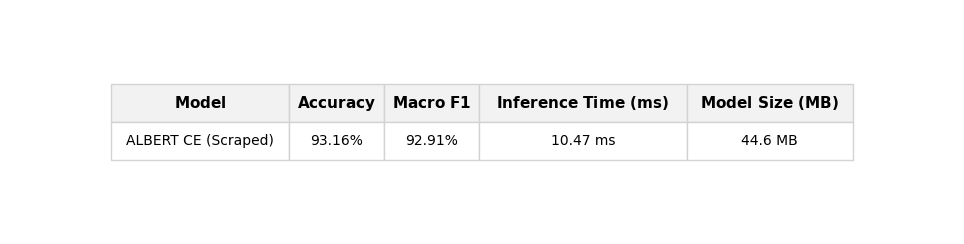

In [ ]:
acc_img, macro_f1_img, infer_ms_img, size_mb_img = model_summary_table(
    student_model_scraped_ce,
    test_loader_ce_scraped,
    model_name="ALBERT CE (Scraped)",
    return_values=True
)

model_summary_image(
    "ALBERT CE (Scraped)",
    acc_img,
    macro_f1_img,
    infer_ms_img,
    size_mb_img
)

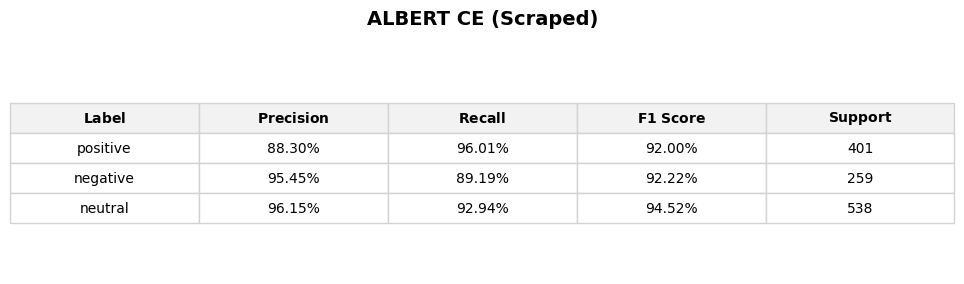

In [ ]:
id2label = teacher_model.config.id2label

per_label_performance_image(
    student_model_scraped_ce,
    test_loader_ce_scraped,
    id2label=id2label,
    title="ALBERT CE (Scraped)"
)

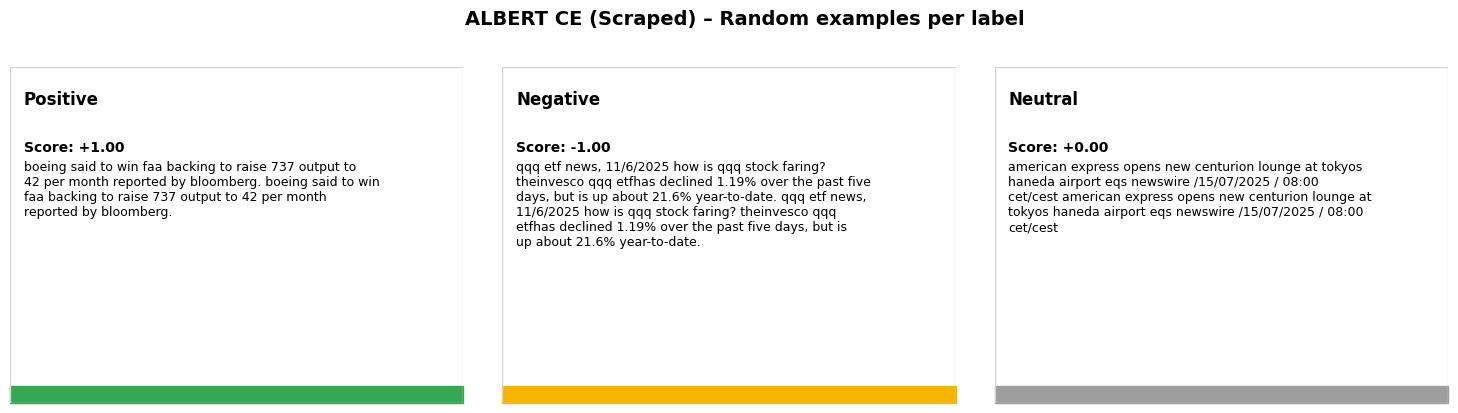

In [ ]:
test_texts = df_test["kd_text"].tolist()
id2label = teacher_model.config.id2label

show_random_label_cards(
    model=student_model_scraped_ce,
    tokenizer=student_tokenizer,
    texts=test_texts,
    id2label=id2label,
    title="ALBERT CE (Scraped) – Random examples per label"
)

## Model Vanilla KD on Scraped Data

| Model                       | Accuracy   | Macro F1   | Inference Time (ms)   | Model Size (MB)   |
|-----------------------------|------------|------------|-----------------------|-------------------|
| ALBERT Vanilla KD (Scraped) | 93.82%     | 93.68%     | 9.03 ms               | 44.6 MB           |


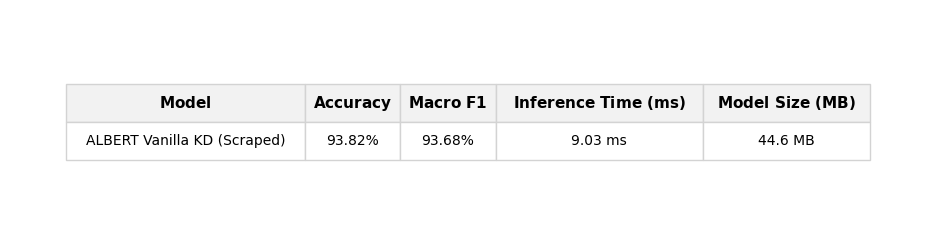

In [ ]:
student_model_kd_scraped = AlbertForSequenceClassification.from_pretrained('albert_vanilla_kd_scraped_T5').to(device)

acc_img_kd, macro_f1_img_kd, infer_ms_img_kd, size_mb_img_kd = model_summary_table(
    student_model_kd_scraped,
    test_loader_kd_scraped,
    model_name="ALBERT Vanilla KD (Scraped)",
    return_values=True
)

model_summary_image(
    "ALBERT Vanilla KD (Scraped)",
    acc_img_kd,
    macro_f1_img_kd,
    infer_ms_img_kd,
    size_mb_img_kd
)

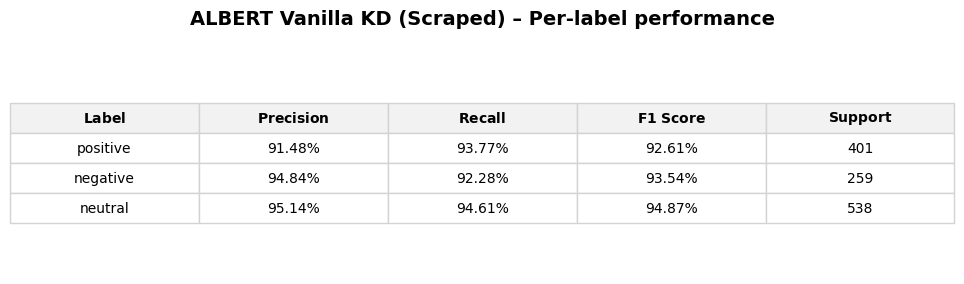

In [ ]:
id2label = teacher_model.config.id2label

per_label_performance_image(
    student_model_kd_scraped,
    test_loader_kd_scraped,
    id2label=id2label,
    title="ALBERT Vanilla KD (Scraped) – Per-label performance"
)

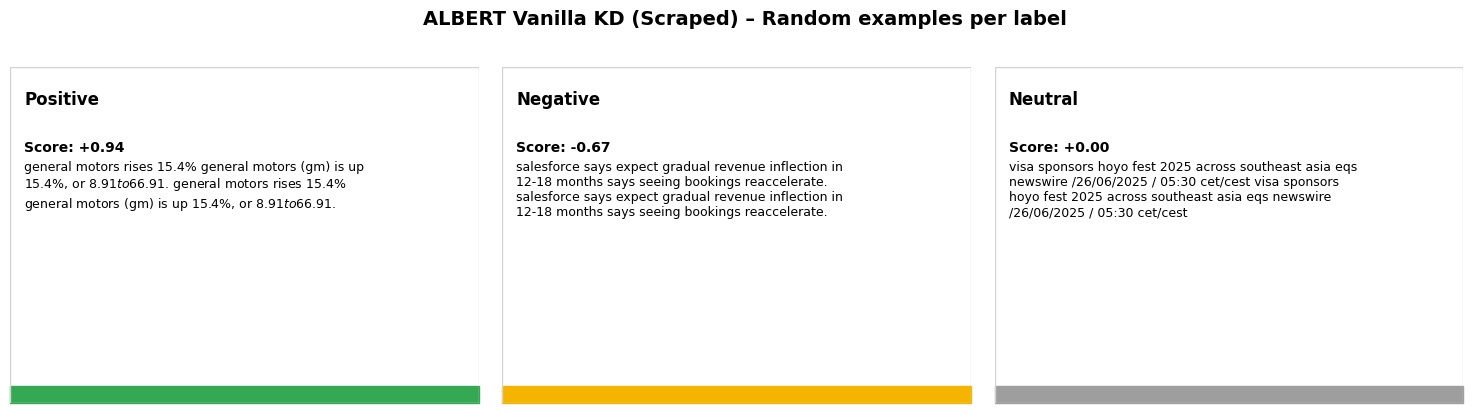

In [ ]:
test_texts_kd = df_test["kd_text"].tolist()   # same test split texts

show_random_label_cards(
    model=student_model_kd_scraped,
    tokenizer=student_tokenizer,
    texts=test_texts_kd,
    id2label=id2label,
    title="ALBERT Vanilla KD (Scraped) – Random examples per label"
)

##  Model Patient KD on Scraped Data

| Model                       | Accuracy   | Macro F1   | Inference Time (ms)   | Model Size (MB)   |
|-----------------------------|------------|------------|-----------------------|-------------------|
| ALBERT Patient KD (Scraped) | 94.07%     | 93.94%     | 9.05 ms               | 44.6 MB           |


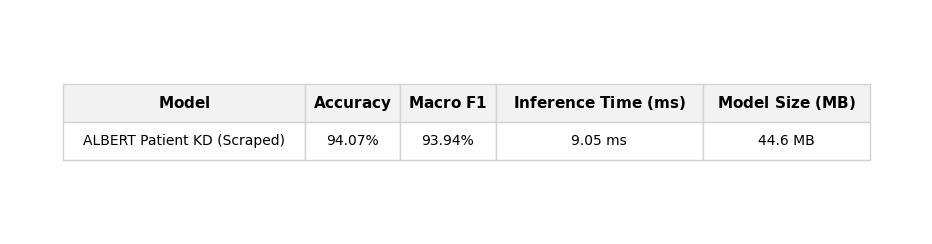

In [ ]:
acc_img_pkd, macro_f1_img_pkd, infer_ms_img_pkd, size_mb_img_pkd = model_summary_table(
    student_model_pkd_scraped,
    test_loader_kd_scraped,
    model_name="ALBERT Patient KD (Scraped)",
    return_values=True
)

model_summary_image(
    "ALBERT Patient KD (Scraped)",
    acc_img_pkd,
    macro_f1_img_pkd,
    infer_ms_img_pkd,
    size_mb_img_pkd
)

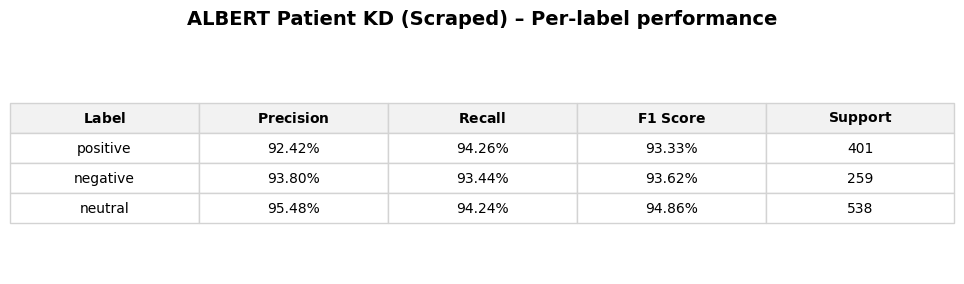

In [ ]:
id2label = teacher_model.config.id2label

per_label_performance_image(
    student_model_pkd_scraped,
    test_loader_kd_scraped,
    id2label=id2label,
    title="ALBERT Patient KD (Scraped) – Per-label performance"
)

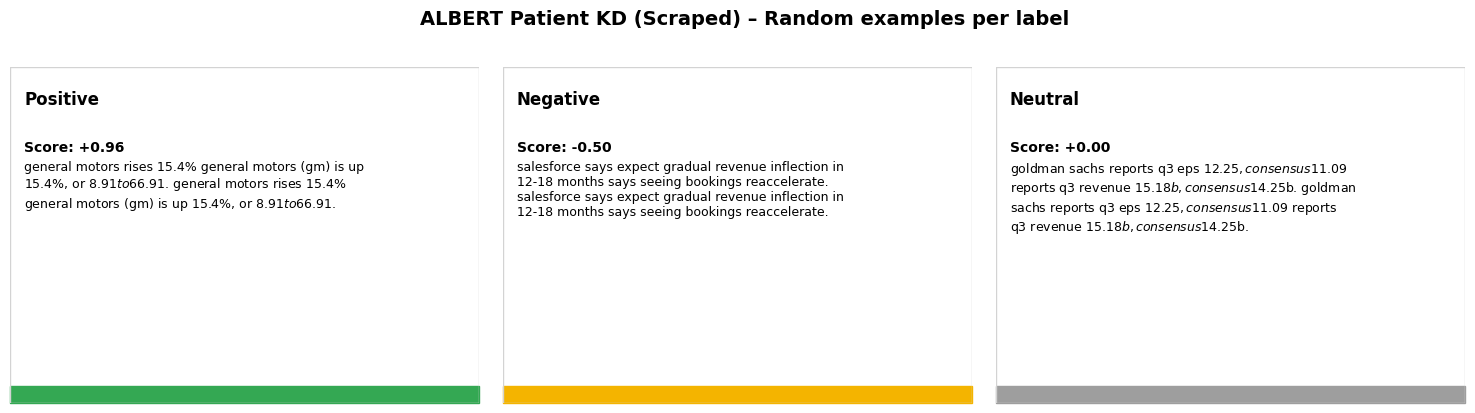

In [ ]:
test_texts_pkd = df_test["kd_text"].tolist()

show_random_label_cards(
    model=student_model_pkd_scraped,
    tokenizer=student_tokenizer,
    texts=test_texts_pkd,
    id2label=id2label,
    title="ALBERT Patient KD (Scraped) – Random examples per label"
)

# Statisitcs on Financial PhraseBank

## Fresh ALBERT on Financial PhraseBank

| Model             | Accuracy   | Macro F1   | Inference Time (ms)   | Model Size (MB)   |
|-------------------|------------|------------|-----------------------|-------------------|
| ALBERT Fresh - FP | 80.29%     | 55.44%     | 10.35 ms              | 44.6 MB           |


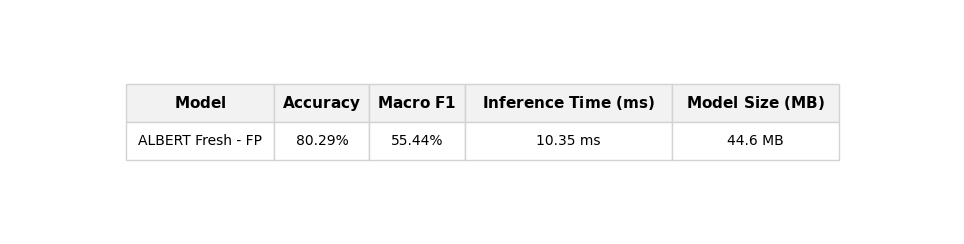

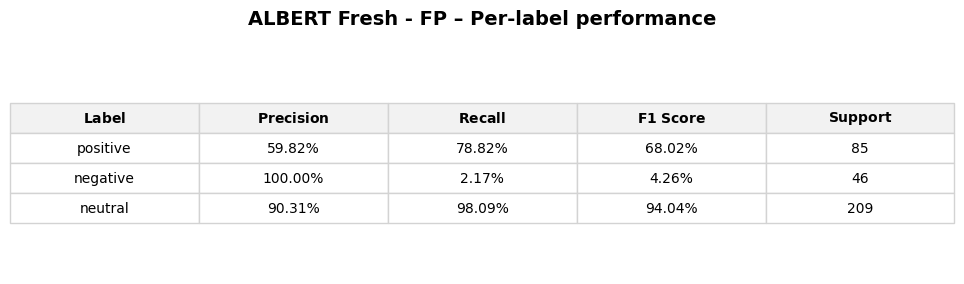

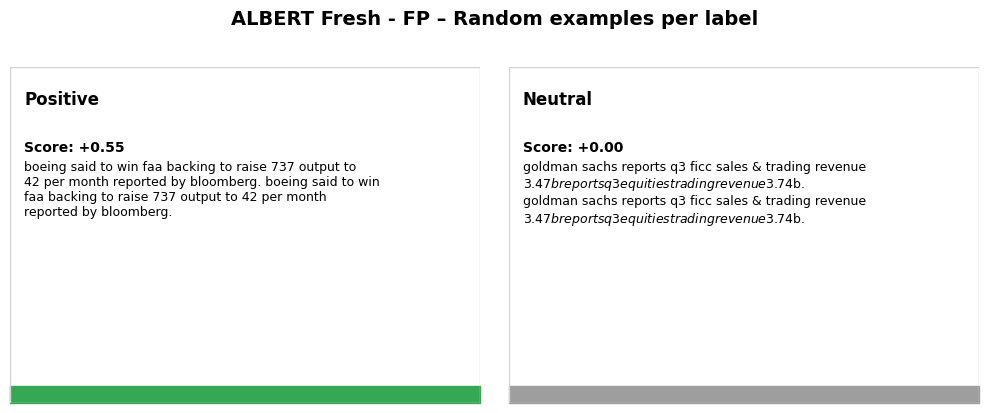

In [ ]:
id2label = {0: "positive", 1: "negative", 2: "neutral"}  # or from teacher

acc_fresh, f1_fresh, infer_fresh, size_fresh = model_summary_table(
    student_fresh_fp,
    test_loader_ce,
    model_name="ALBERT Fresh - FP",
    return_values=True
)

model_summary_image(
    "ALBERT Fresh - FP",
    acc_fresh,
    f1_fresh,
    infer_fresh,
    size_fresh
)

per_label_performance_image(
    student_fresh_fp,
    test_loader_ce,
    id2label=id2label,
    title="ALBERT Fresh - FP – Per-label performance"
)

show_random_label_cards(
    model=student_fresh_fp,
    tokenizer=student_tokenizer,
    texts=test_texts,
    id2label=id2label,
    title="ALBERT Fresh - FP – Random examples per label"
)

## Model CE-scraped on Financial Phrasebank

| Model                  | Accuracy   | Macro F1   | Inference Time (ms)   | Model Size (MB)   |
|------------------------|------------|------------|-----------------------|-------------------|
| ALBERT CE-Scraped - FP | 95.29%     | 93.13%     | 9.91 ms               | 44.6 MB           |


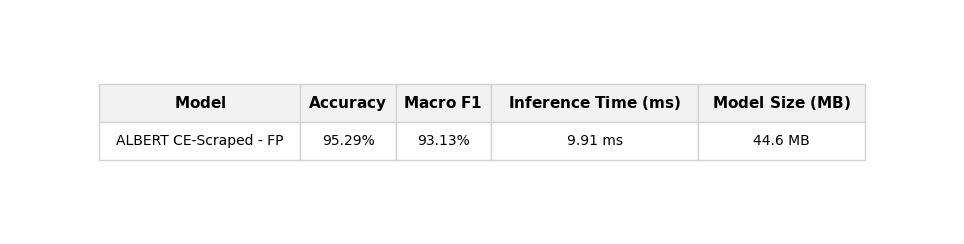

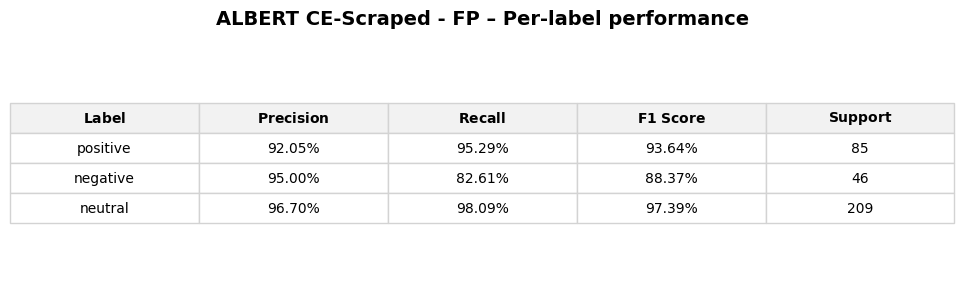

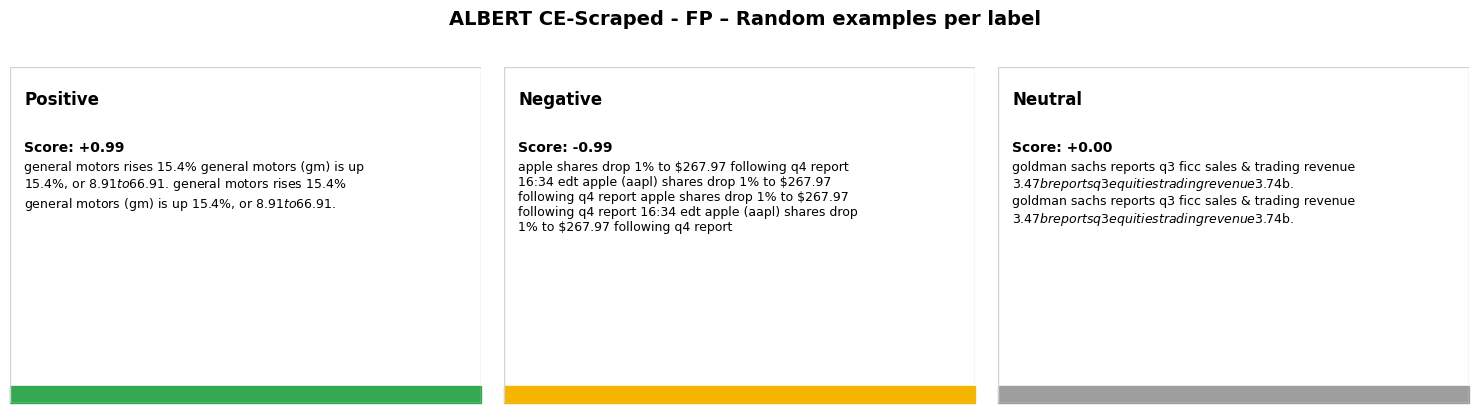

In [ ]:
acc_ce, f1_ce, infer_ce, size_ce = model_summary_table(
    student_ce_scraped,
    test_loader_ce,
    model_name="ALBERT CE-Scraped - FP",
    return_values=True
)

model_summary_image(
    "ALBERT CE-Scraped - FP",
    acc_ce,
    f1_ce,
    infer_ce,
    size_ce
)

per_label_performance_image(
    student_ce_scraped,
    test_loader_ce,
    id2label=id2label,
    title="ALBERT CE-Scraped - FP – Per-label performance"
)

show_random_label_cards(
    model=student_ce_scraped,
    tokenizer=student_tokenizer,
    texts=test_texts,
    id2label=id2label,
    title="ALBERT CE-Scraped - FP – Random examples per label"
)

## Model Vanilla KD-scapred on Financial Phrasebank

| Model                  | Accuracy   | Macro F1   | Inference Time (ms)   | Model Size (MB)   |
|------------------------|------------|------------|-----------------------|-------------------|
| ALBERT KD-Scraped - FP | 96.47%     | 95.25%     | 10.19 ms              | 44.6 MB           |


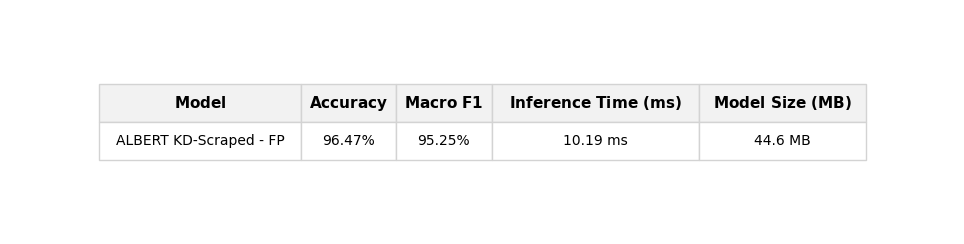

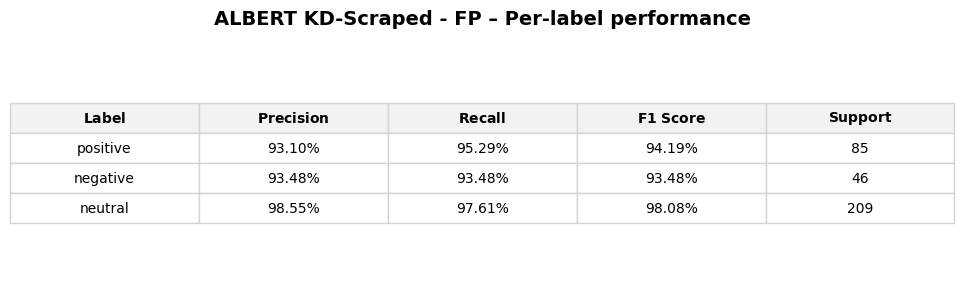

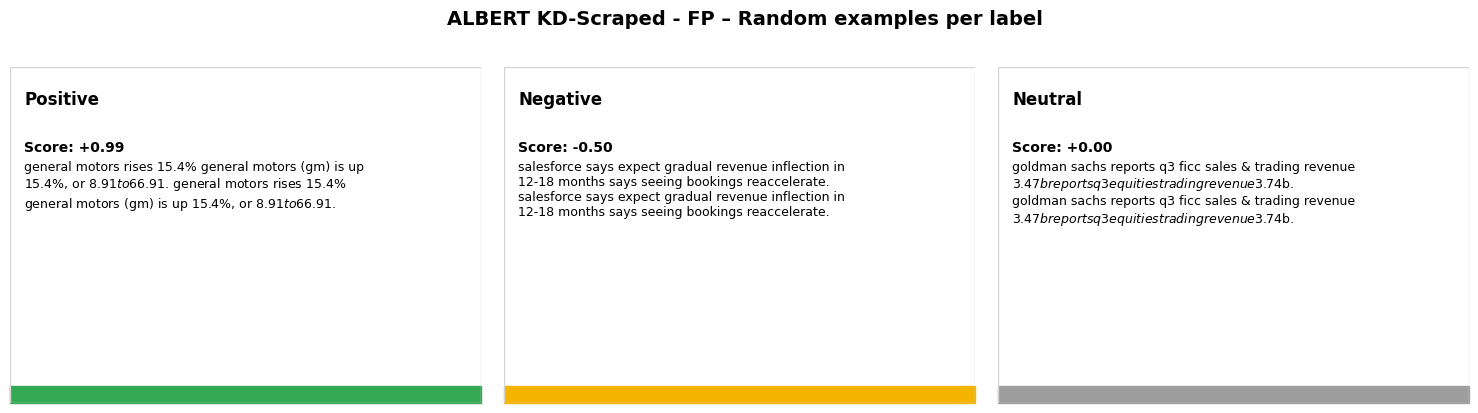

In [ ]:
acc_kd, f1_kd, infer_kd, size_kd = model_summary_table(
    results_kd_scraped_fp,
    test_loader_ce,
    model_name="ALBERT KD-Scraped - FP",
    return_values=True
)

model_summary_image(
    "ALBERT KD-Scraped - FP",
    acc_kd,
    f1_kd,
    infer_kd,
    size_kd
)

per_label_performance_image(
    results_kd_scraped_fp,
    test_loader_ce,
    id2label=id2label,
    title="ALBERT KD-Scraped - FP – Per-label performance"
)

show_random_label_cards(
    model=results_kd_scraped_fp,
    tokenizer=student_tokenizer,
    texts=test_texts,
    id2label=id2label,
    title="ALBERT KD-Scraped - FP – Random examples per label"
)

## Model Patient KD-scraped on Financial Phrasebank

| Model                   | Accuracy   | Macro F1   | Inference Time (ms)   | Model Size (MB)   |
|-------------------------|------------|------------|-----------------------|-------------------|
| ALBERT PKD-Scraped - FP | 97.35%     | 96.26%     | 10.32 ms              | 44.6 MB           |


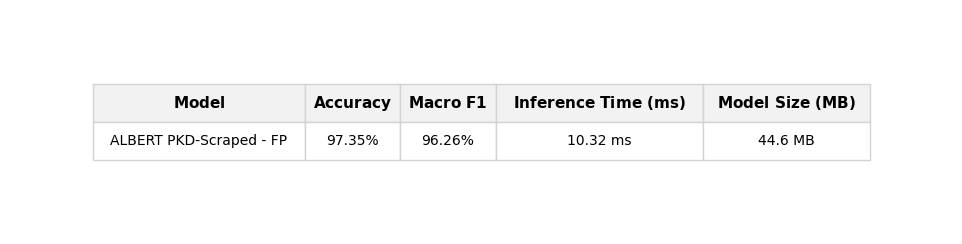

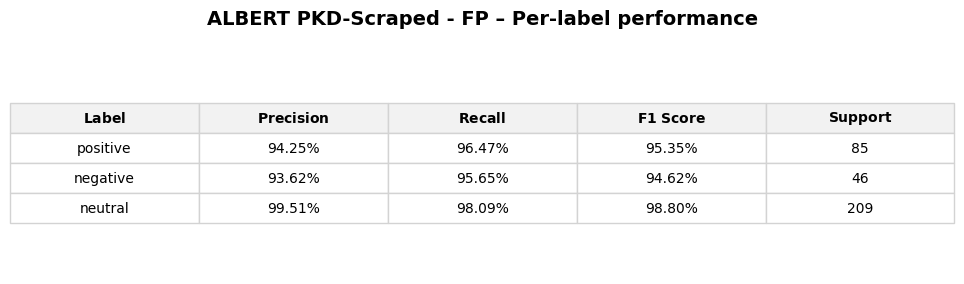

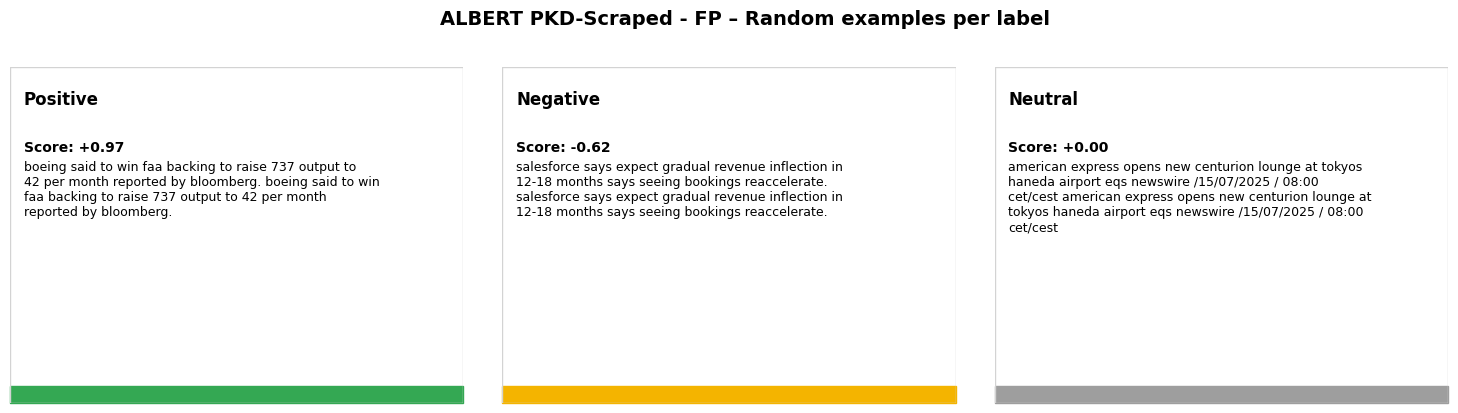

In [ ]:
acc_pkd, f1_pkd, infer_pkd, size_pkd = model_summary_table(
    student_pkd_scraped,
    test_loader_ce,
    model_name="ALBERT PKD-Scraped - FP",
    return_values=True
)

model_summary_image(
    "ALBERT PKD-Scraped - FP",
    acc_pkd,
    f1_pkd,
    infer_pkd,
    size_pkd
)

per_label_performance_image(
    student_pkd_scraped,
    test_loader_ce,
    id2label=id2label,
    title="ALBERT PKD-Scraped - FP – Per-label performance"
)

show_random_label_cards(
    model=student_pkd_scraped,
    tokenizer=student_tokenizer,
    texts=test_texts,
    id2label=id2label,
    title="ALBERT PKD-Scraped - FP – Random examples per label"
)

# Leaderboard

## Helper Functions

In [ ]:
import matplotlib.pyplot as plt

def model_leaderboard_image(models, title="Model Leaderboard"):

    # Sort models for leaderboard
    # accuracy (desc), then F1 (desc), then inference time (asc),
    # then size (asc)
    models_sorted = sorted(
        models,
        key=lambda m: (-m["accuracy"], -m["f1"], m["infer_ms"], m["size_mb"])
    )

    # Build table data
    cell_text = []
    for m in models_sorted:
        cell_text.append([
            m["name"],
            f"{m['accuracy']*100:.2f}%",
            f"{m['f1']*100:.2f}%",
            f"{m['infer_ms']:.2f} ms",
            f"{m['size_mb']:.1f} MB"
        ])

    # Column labels
    col_labels = [
        r"$\bf{Model}$",
        r"$\bf{Accuracy}$",
        r"$\bf{Macro\ F1}$",
        r"$\bf{Inference\ Time\ (ms)}$",
        r"$\bf{Model\ Size\ (MB)}$"
    ]

    # Draw table as image
    n_rows = len(models_sorted)
    fig_height = max(2.5, 0.6 * (n_rows + 1))

    fig, ax = plt.subplots(figsize=(10, fig_height))
    ax.axis("off")

    table = ax.table(
        cellText=cell_text,
        colLabels=col_labels,
        loc="center",
        cellLoc="center"
    )

    table.scale(1, 1.6)

    for (row, col), cell in table.get_celld().items():
        if row == 0:
            cell.set_facecolor("#f2f2f2")
            cell.set_edgecolor("lightgray")
            cell.set_text_props(ha="center", va="center", fontsize=11)
        else:
            cell.set_edgecolor("lightgray")
            cell.set_text_props(ha="center", va="center", fontsize=10)

    table.auto_set_font_size(False)
    table.auto_set_column_width(col=list(range(len(col_labels))))

    # Title
    plt.title(title, fontsize=14, fontweight="bold", pad=20)

    plt.tight_layout(pad=2.0)
    plt.show()

## Web scapred Data

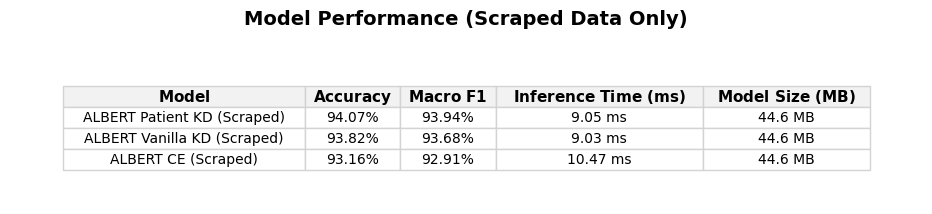

In [ ]:
models_scraped = [
    {
        "name": "ALBERT CE (Scraped)",
        "accuracy": acc_img,
        "f1": macro_f1_img,
        "infer_ms": infer_ms_img,
        "size_mb": size_mb_img
    },
    {
        "name": "ALBERT Vanilla KD (Scraped)",
        "accuracy": acc_img_kd,
        "f1": macro_f1_img_kd,
        "infer_ms": infer_ms_img_kd,
        "size_mb": size_mb_img_kd
    },
    {
        "name": "ALBERT Patient KD (Scraped)",
        "accuracy": acc_img_pkd,
        "f1": macro_f1_img_pkd,
        "infer_ms": infer_ms_img_pkd,
        "size_mb": size_mb_img_pkd
    }
]

model_leaderboard_image(
    models_scraped,
    title="Model Performance (Scraped Data Only)"
)

## Financial Phrasebank

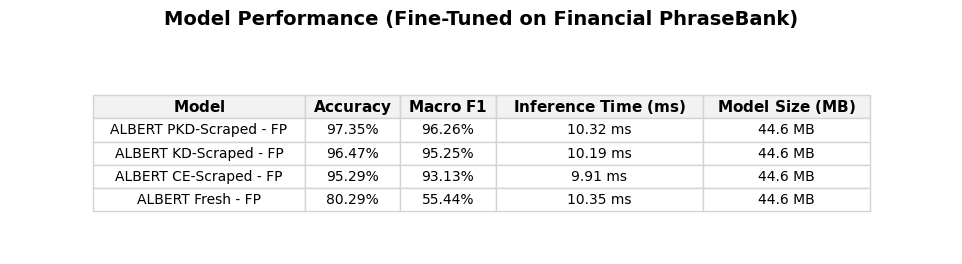

In [ ]:
models_fp = [
    {
        "name": "ALBERT Fresh - FP",
        "accuracy": acc_fresh,
        "f1": f1_fresh,
        "infer_ms": infer_fresh,
        "size_mb": size_fresh
    },
    {
        "name": "ALBERT CE-Scraped - FP",
        "accuracy": acc_ce,
        "f1": f1_ce,
        "infer_ms": infer_ce,
        "size_mb": size_ce
    },
    {
        "name": "ALBERT KD-Scraped - FP",
        "accuracy": acc_kd,
        "f1": f1_kd,
        "infer_ms": infer_kd,
        "size_mb": size_kd
    },
    {
        "name": "ALBERT PKD-Scraped - FP",
        "accuracy": acc_pkd,
        "f1": f1_pkd,
        "infer_ms": infer_pkd,
        "size_mb": size_pkd
    }
]

model_leaderboard_image(
    models=models_fp,
    title="Model Performance (Fine-Tuned on Financial PhraseBank)"
)